# loading

In [1]:
import pandas
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.layers import (BatchNormalization,Flatten,Convolution1D,Activation,Input,Dense,LSTM)
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
from keras import losses, models, optimizers
import tensorflow as tf
from tensorflow.keras import losses, models, optimizers
import random as rn
import warnings
import os
from math import sqrt

import tensorflow.python.keras.backend as K

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/UCL/data/'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
# load train and test data (ShearStress) (from Laurenti et al.)
df_p4581 = pandas.read_csv(path+"newDF_TimeToFailure_from_3800_to_4100_WITHOUT_subwindows.csv")[["Var_Ch1", "Var_Ch2", "ShearStress"]]
df_p4679 = pandas.read_csv(path+"newDF_TimeToFailure_from_4340_to_4540_WITHOUT_subwindows_len003_shifth003.csv")[["Var_Ch1", "Var_Ch2", "ShearStress"]]
df_p5198 = pandas.read_csv(path+"newDF_TimeToFailure_from_6600_to_6900_WITHOUT_subwindows.csv")[["Var_Ch1", "Var_Ch2", "ShearStress"]]

In [ ]:
# load train and test data (TTsF) (from Laurenti et al.)
df_p4581 = pandas.read_csv(path+"newDF_TimeToFailure_from_3800_to_4100_WITHOUT_subwindows.csv")[["Var_Ch1", "Var_Ch2", "TimeToStartFailure"]]
df_p4679 = pandas.read_csv(path+"newDF_TimeToFailure_from_4340_to_4540_WITHOUT_subwindows_len003_shifth003.csv")[["Var_Ch1", "Var_Ch2", "TimeToStartFailure"]]
df_p5198 = pandas.read_csv(path+"newDF_TimeToFailure_from_6600_to_6900_WITHOUT_subwindows.csv")[["Var_Ch1", "Var_Ch2", "TimeToStartFailure"]]

In [ ]:
df_p5198

,Var_Ch1,Var_Ch2,TimeToStartFailure
0,33.115246,59.167182,0.0
1,30.498154,54.023189,5.3
2,24.764192,42.132384,5.2
3,16.365748,25.389811,5.1
4,13.040798,18.970351,5.0
...,...,...,...
3004,9.480750,12.555576,0.4
3005,9.565471,12.708317,0.3
3006,9.623739,12.901281,0.2
3007,9.703154,13.074844,0.1


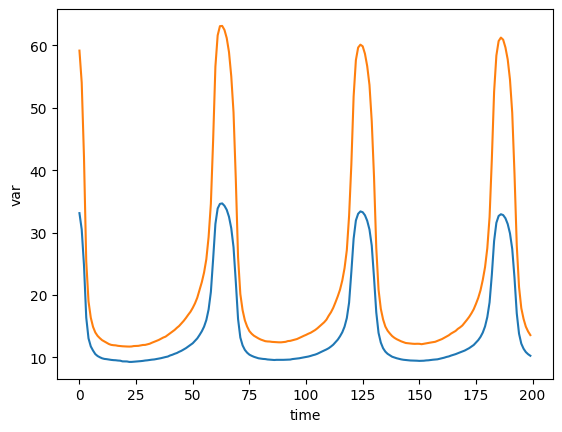

In [ ]:
plt.plot(df_p5198["Var_Ch1"][:200])
plt.plot(df_p5198["Var_Ch2"][:200])
plt.xlabel('time')
plt.ylabel('var')
plt.show()

In [5]:
def train_test_split_func(data_DF, train_percentage, steps):
  train_size = int(len(data_DF) * train_percentage)
  dataset_train = data_DF[0:train_size]
  training_set = dataset_train.iloc[:, 0:dataset_train.shape[1]].values
  # dataset_test = data_DF[train_size-steps:len(data_DF)]
  dataset_test = data_DF[train_size:len(data_DF)]
  test_set= dataset_test.iloc[:, 0:dataset_test.shape[1]].values
  real_value = dataset_test.iloc[:, -1].values
  sc = MinMaxScaler()
  training_set_scaled = sc.fit_transform(training_set)
  print("training_set.shape: ",training_set.shape)
  X_train = []
  y_train = []
  for i in range(steps, training_set.shape[0]):
      X_train.append(training_set_scaled[i-steps:i, 0:training_set.shape[1]-1])
      y_train.append(training_set_scaled[i, training_set.shape[1]-1:])
  X_train, y_train = np.array(X_train), np.array(y_train)
  print("X_train.shape: ",X_train.shape)
  print("y_train.shape: ",y_train.shape)
  test_set_scaled = sc.fit_transform(test_set)
  X_test = []
  y_test = []
  for i in range(steps, test_set.shape[0]):
      X_test.append(test_set_scaled[i-steps:i, 0:test_set.shape[1]-1])
      y_test.append(test_set_scaled[i, test_set.shape[1]-1:])
  X_test = np.array(X_test)
  y_test = np.array(y_test)
  print("X_test.shape: ",X_test.shape)
  print("y_test.shape: ",y_test.shape)

  return X_train, y_train, X_test, y_test

In [6]:
# val split
def val_rand_split(set_X, set_y, val_percentage):
  # remove the seed first
  np.random.seed(None)
  rn.seed(None)
  tf.random.set_seed(None)

  train_X, val_X, train_y, val_y = train_test_split(set_X, set_y, test_size=val_percentage)
  return train_X, train_y, val_X, val_y

def val_normal_split(set_X, set_y, val_percentage, steps):
  val_size = int(set_X.shape[0] * val_percentage)
  train_X = set_X[:set_X.shape[0]-val_size-steps]
  train_y = set_y[:set_X.shape[0]-val_size-steps]
  val_X = set_X[set_X.shape[0]-val_size:]
  val_y = set_y[set_X.shape[0]-val_size:]

  return train_X, train_y, val_X, val_y

In [7]:
def test_step(model, X_test, y_test, steps):
  predicted = model.predict(X_test,verbose=1 )
  rmse = sqrt(mean_squared_error(y_test[:len(y_test)-steps], predicted[:len(y_test)-steps]))
  r2=r2_score(y_test[:len(y_test)-steps], predicted[:len(y_test)-steps])
  print('Test r2_score: %.5f' % r2)
  print('Test RMSE: %.5f' % rmse)
  results = model.evaluate(X_test, y_test, batch_size = 128)
  print("test loss:", results)
  return rmse, r2, results

In [ ]:
train_percentage = 0.7
val_percentage = 0.1
steps_p5198 = 70
steps_p4679_ss = 2000
steps_p4679_ttf = 1717
steps_p4581 = 70
early_stopping = 40
max_epoch = 250

In [ ]:
# change this block to change the dataset
steps = steps_p5198
X_train, y_train, X_test, y_test = train_test_split_func(df_p5198, train_percentage, steps)

training_set.shape:  (2106, 3)
X_train.shape:  (2036, 70, 2)
y_train.shape:  (2036, 1)
X_test.shape:  (833, 70, 2)
y_test.shape:  (833, 1)


train: 


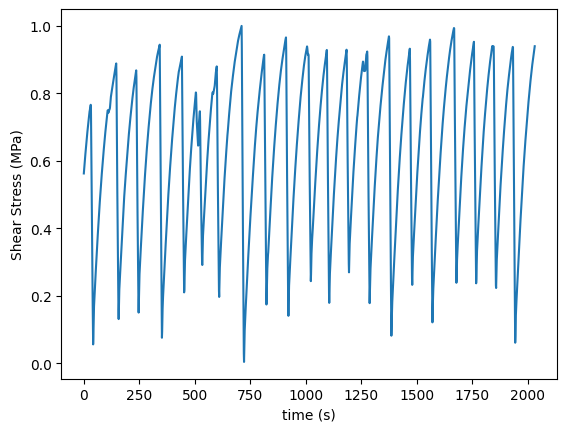

test: 


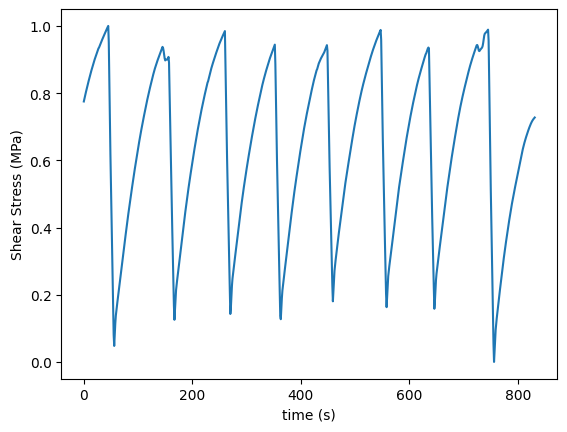

In [ ]:
print("train: ")
plt.plot(y_train)
plt.xlabel('time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.show()
print("test: ")
plt.plot(y_test)
plt.xlabel('time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.show()

# part 1

In [ ]:
# train (init)
# set seed
np.random.seed(1234)
rn.seed(1234)
tf.random.set_seed(1234)
if device == 'cuda':
  os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

class myCallback(tf.keras.callbacks.Callback):
  def __init__(self):
    super().__init__()
    self.testResults=[]
  def on_epoch_end(self, epoch, logs={}):
      restest=model.predict(X_test)
      testResults.append(mean_squared_error(y_test,restest))


testResults=[]
inp = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = BatchNormalization()(inp)
x = LSTM(128,return_sequences=True)(x)
x = Convolution1D(128, (2),activation='relu', padding="same")(x)
x = Convolution1D(84, (2),activation='relu', padding="same")(x)
x = Convolution1D(64, (2),activation='relu', padding="same")(x)

x = Flatten()(x)

x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)


ttf = Dense(1, activation='relu',name='regressor')(x)

model = models.Model(inputs=inp, outputs=ttf)
model.get_weights()

[array([1., 1.], dtype=float32),
 array([0., 0.], dtype=float32),
 array([0., 0.], dtype=float32),
 array([1., 1.], dtype=float32),
 array([[ 0.02176407,  0.07631259,  0.00779288, ...,  0.0106303 ,
          0.05593288,  0.08650576],
        [-0.0013248 , -0.08735823, -0.10493924, ...,  0.05134355,
          0.003539  , -0.01286237]], dtype=float32),
 array([[-0.01784134, -0.03931972, -0.02630295, ...,  0.03682534,
          0.02034263, -0.02123926],
        [ 0.00111194,  0.04051864, -0.06480549, ...,  0.05769073,
         -0.09736598, -0.01700813],
        [-0.01242469,  0.03978812, -0.05305326, ...,  0.0885902 ,
         -0.01232543, -0.05853194],
        ...,
        [-0.01910844, -0.01725128, -0.03811354, ..., -0.02139422,
          0.03623503, -0.0382143 ],
        [-0.02090617,  0.00067238, -0.01463811, ..., -0.0243874 ,
         -0.00037052,  0.13361895],
        [-0.03228055, -0.08242818,  0.00527645, ..., -0.08868441,
         -0.05463694,  0.01435535]], dtype=float32),
 arra

In [ ]:
model.count_params()

421277

In [ ]:
# train (normal)
opt = optimizers.Nadam(learning_rate=0.008)

model.compile(optimizer = opt, loss = 'mean_squared_error')

checkpoint_filepath = 'model.hdf5'
cb_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss',mode='min', save_weights_only=True,save_best_only=True)
cb_Early_Stop=EarlyStopping(monitor='val_loss',patience=20,mode='min', verbose=1)
cb_Reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


callbacks = [cb_checkpoint,cb_Early_Stop,cb_Reduce_LR, myCallback()]

os.environ['PYTHONHASHSEED'] = '0'
session_conf = tf.compat.v1.ConfigProto(allow_soft_placement=True)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

K.set_session(sess)

history=model.fit(X_train, y_train, epochs=120,callbacks=callbacks, batch_size=256,verbose=1,validation_split=0.1)
#model.load_weights("model.hdf5")

Epoch 1/120
8/8 [==============================] - 9s 483ms/step - loss: 2.3308 - val_loss: 0.0972 - lr: 0.0080
Epoch 2/120
8/8 [==============================] - 3s 333ms/step - loss: 0.0385 - val_loss: 0.0699 - lr: 0.0080
Epoch 3/120
8/8 [==============================] - 3s 333ms/step - loss: 0.0097 - val_loss: 0.0707 - lr: 0.0080
Epoch 4/120
8/8 [==============================] - 3s 418ms/step - loss: 0.0043 - val_loss: 0.0504 - lr: 0.0080
Epoch 5/120
8/8 [==============================] - 3s 327ms/step - loss: 0.0026 - val_loss: 0.0514 - lr: 0.0080
Epoch 6/120
8/8 [==============================] - 3s 412ms/step - loss: 0.0022 - val_loss: 0.0420 - lr: 0.0080
Epoch 7/120
8/8 [==============================] - 2s 317ms/step - loss: 0.0022 - val_loss: 0.0515 - lr: 0.0080
Epoch 8/120
8/8 [==============================] - 3s 345ms/step - loss: 0.0027 - val_loss: 0.0381 - lr: 0.0080
Epoch 9/120
8/8 [==============================] - 3s 421ms/step - loss: 0.0014 - val_loss: 0.0330 - lr:

In [ ]:
# test (normal)
test_step(model, X_test, y_test, steps)

29/29 [==============================] - 1s 35ms/step
Test r2_score: 0.93125
Test RMSE: 0.06487
8/8 [==============================] - 1s 65ms/step - loss: 0.0048
test loss: 0.0048469374887645245


(0.06486597015864788, 0.9312468786536026, 0.0048469374887645245)

# part 2 - random validation set experiment

In [ ]:
# get val set
train_X, train_y, val_X, val_y = val_rand_split(X_train, y_train, val_percentage)
# train
np.random.seed(1234)
rn.seed(1234)
tf.random.set_seed(1234)
if device == 'cuda':
  os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

class myCallback(tf.keras.callbacks.Callback):
  def __init__(self):
    super().__init__()
    self.testResults=[]
  def on_epoch_end(self, epoch, logs={}):
      restest=model.predict(X_test)
      testResults.append(mean_squared_error(y_test,restest))


testResults=[]
inp = Input(shape=(train_X.shape[1], train_X.shape[2]))
x = BatchNormalization()(inp)
x = LSTM(128,return_sequences=True)(x)
x = Convolution1D(128, (2),activation='relu', padding="same")(x)
x = Convolution1D(84, (2),activation='relu', padding="same")(x)
x = Convolution1D(64, (2),activation='relu', padding="same")(x)

x = Flatten()(x)

x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)


ttf = Dense(1, activation='relu',name='regressor')(x)

model = models.Model(inputs=inp, outputs=ttf)

opt = optimizers.Nadam(learning_rate=0.008)

model.compile(optimizer = opt, loss = 'mean_squared_error')

checkpoint_filepath = 'model.hdf5'
cb_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss',mode='min', save_weights_only=True,save_best_only=True)
cb_Early_Stop=EarlyStopping(monitor='val_loss',patience=early_stopping,mode='min', verbose=1)
cb_Reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


callbacks = [cb_checkpoint,cb_Early_Stop,cb_Reduce_LR, myCallback()]

os.environ['PYTHONHASHSEED'] = '0'
session_conf = tf.compat.v1.ConfigProto(allow_soft_placement=True)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

K.set_session(sess)

history=model.fit(train_X, train_y, epochs=max_epoch,callbacks=callbacks, batch_size=256,verbose=1,validation_data=(val_X, val_y))

Epoch 1/250
8/8 [==============================] - 9s 536ms/step - loss: 2.1547 - val_loss: 0.1666 - lr: 0.0080
Epoch 2/250
8/8 [==============================] - 3s 407ms/step - loss: 0.0440 - val_loss: 0.0704 - lr: 0.0080
Epoch 3/250
8/8 [==============================] - 3s 431ms/step - loss: 0.0250 - val_loss: 0.0454 - lr: 0.0080
Epoch 4/250
8/8 [==============================] - 3s 443ms/step - loss: 0.0215 - val_loss: 0.0438 - lr: 0.0080
Epoch 5/250
8/8 [==============================] - 3s 369ms/step - loss: 0.0211 - val_loss: 0.0435 - lr: 0.0080
Epoch 6/250
8/8 [==============================] - 3s 372ms/step - loss: 0.0200 - val_loss: 0.0345 - lr: 0.0080
Epoch 7/250
8/8 [==============================] - 3s 365ms/step - loss: 0.0207 - val_loss: 0.0381 - lr: 0.0080
Epoch 8/250
8/8 [==============================] - 3s 441ms/step - loss: 0.0187 - val_loss: 0.0358 - lr: 0.0080
Epoch 9/250
8/8 [==============================] - 3s 352ms/step - loss: 0.0189 - val_loss: 0.0392 - lr:

In [ ]:
# train loss
test_step(model, train_X, train_y, steps)

58/58 [==============================] - 2s 31ms/step
Test r2_score: 0.93950
Test RMSE: 0.06723
15/15 [==============================] - 1s 63ms/step - loss: 0.0046
test loss: 0.004580821376293898


(0.06723468256368305, 0.9395031290842875, 0.004580821376293898)

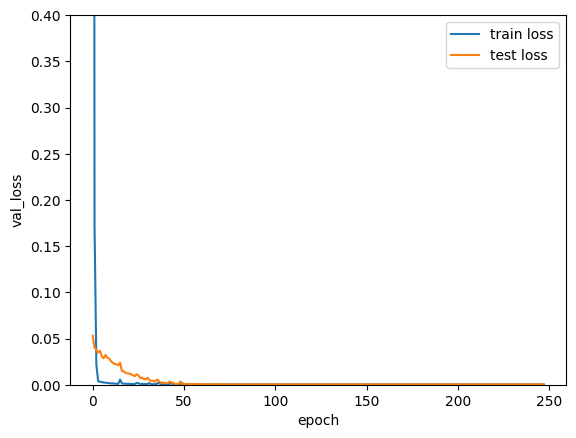

In [ ]:
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="test loss")
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.ylim([0, 0.4])
plt.legend()
plt.show()

In [ ]:
# train 10 times and get average:
test_r2 = []
test_rmse = []
test_loss = []
for i in range(10):
  print(i, " times")
  # get val set
  train_X, train_y, val_X, val_y = val_rand_split(X_train, y_train, val_percentage)
  # train
  np.random.seed(1234)
  rn.seed(1234)
  tf.random.set_seed(1234)
  if device == 'cuda':
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

  class myCallback(tf.keras.callbacks.Callback):
    def __init__(self):
      super().__init__()
      self.testResults=[]
    def on_epoch_end(self, epoch, logs={}):
        restest=model.predict(X_test)
        testResults.append(mean_squared_error(y_test,restest))


  testResults=[]
  inp = Input(shape=(train_X.shape[1], train_X.shape[2]))
  x = BatchNormalization()(inp)
  x = LSTM(128,return_sequences=True)(x)
  x = Convolution1D(128, (2),activation='relu', padding="same")(x)
  x = Convolution1D(84, (2),activation='relu', padding="same")(x)
  x = Convolution1D(64, (2),activation='relu', padding="same")(x)

  x = Flatten()(x)

  x = Dense(64, activation="relu")(x)
  x = Dense(32, activation="relu")(x)


  ttf = Dense(1, activation='relu',name='regressor')(x)

  model = models.Model(inputs=inp, outputs=ttf)

  opt = optimizers.Nadam(learning_rate=0.008)

  model.compile(optimizer = opt, loss = 'mean_squared_error')

  checkpoint_filepath = 'model.hdf5'
  cb_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss',mode='min', save_weights_only=True,save_best_only=True)
  cb_Early_Stop=EarlyStopping(monitor='val_loss',patience=early_stopping,mode='min', verbose=1)
  cb_Reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


  callbacks = [cb_checkpoint,cb_Early_Stop,cb_Reduce_LR, myCallback()]

  os.environ['PYTHONHASHSEED'] = '0'
  session_conf = tf.compat.v1.ConfigProto(allow_soft_placement=True)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

  K.set_session(sess)

  history=model.fit(train_X, train_y, epochs=max_epoch,callbacks=callbacks, batch_size=256,verbose=1,validation_data=(val_X, val_y))

  # test
  rmse, r2, results = test_step(model, X_test, y_test, steps)
  test_rmse.append(rmse)
  test_r2.append(r2)
  test_loss.append(results)

0  times
Epoch 1/250
8/8 [==============================] - 10s 642ms/step - loss: 2.2403 - val_loss: 0.1598 - lr: 0.0080
Epoch 2/250
8/8 [==============================] - 3s 429ms/step - loss: 0.0385 - val_loss: 0.1379 - lr: 0.0080
Epoch 3/250
8/8 [==============================] - 4s 484ms/step - loss: 0.0265 - val_loss: 0.0831 - lr: 0.0080
Epoch 4/250
8/8 [==============================] - 4s 521ms/step - loss: 0.0195 - val_loss: 0.0771 - lr: 0.0080
Epoch 5/250
8/8 [==============================] - 4s 444ms/step - loss: 0.0182 - val_loss: 0.0922 - lr: 0.0080
Epoch 6/250
8/8 [==============================] - 3s 425ms/step - loss: 0.0194 - val_loss: 0.0680 - lr: 0.0080
Epoch 7/250
8/8 [==============================] - 4s 483ms/step - loss: 0.0168 - val_loss: 0.0625 - lr: 0.0080
Epoch 8/250
8/8 [==============================] - 4s 541ms/step - loss: 0.0160 - val_loss: 0.0720 - lr: 0.0080
Epoch 9/250
8/8 [==============================] - 4s 479ms/step - loss: 0.0166 - val_loss: 0.

In [ ]:
print("r2 score: ", np.mean(test_r2), "+-", np.std(test_r2))
print("rmse: ", np.mean(test_rmse), "+-", np.std(test_rmse))
print("test loss: ", np.mean(test_loss), "+-", np.std(test_loss))

r2 score:  0.9215603589853538 +- 0.008744084512429013
rmse:  0.07670805275408393 +- 0.004354149939955786
test loss:  0.008336517633870244 +- 0.0008770293852563448


# part 2 - last 10% selected as validation set

In [ ]:
# last 10% of train as val set
train_X, train_y, val_X, val_y = val_normal_split(X_train, y_train, val_percentage, steps)

# init
# set seed
np.random.seed(1234)
rn.seed(1234)
tf.random.set_seed(1234)
if device == 'cuda':
  os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

class myCallback(tf.keras.callbacks.Callback):
  def __init__(self):
    super().__init__()
    self.testResults=[]
  def on_epoch_end(self, epoch, logs={}):
      restest=model.predict(X_test)
      testResults.append(mean_squared_error(y_test,restest))


testResults=[]
inp = Input(shape=(train_X.shape[1], train_X.shape[2]))
x = BatchNormalization()(inp)
x = LSTM(128,return_sequences=True)(x)
x = Convolution1D(128, (2),activation='relu', padding="same")(x)
x = Convolution1D(84, (2),activation='relu', padding="same")(x)
x = Convolution1D(64, (2),activation='relu', padding="same")(x)

x = Flatten()(x)

x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)


ttf = Dense(1, activation='relu',name='regressor')(x)

model = models.Model(inputs=inp, outputs=ttf)
model.get_weights()

# train
opt = optimizers.Nadam(learning_rate=0.008)

model.compile(optimizer = opt, loss = 'mean_squared_error')

checkpoint_filepath = 'model.hdf5'
cb_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss',mode='min', save_weights_only=True,save_best_only=True)
cb_Early_Stop = EarlyStopping(monitor='val_loss',patience=early_stopping,mode='min', verbose=1)
cb_Reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


callbacks = [cb_checkpoint,cb_Early_Stop,cb_Reduce_LR, myCallback()]

os.environ['PYTHONHASHSEED'] = '0'
session_conf = tf.compat.v1.ConfigProto(allow_soft_placement=True)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

K.set_session(sess)

last10_history=model.fit(train_X, train_y, epochs=max_epoch,callbacks=callbacks, batch_size=256,verbose=1,validation_data=(val_X, val_y))

Epoch 1/250
7/7 [==============================] - 9s 582ms/step - loss: 2.5345 - val_loss: 0.1481 - lr: 0.0080
Epoch 2/250
7/7 [==============================] - 3s 390ms/step - loss: 0.1786 - val_loss: 0.0636 - lr: 0.0080
Epoch 3/250
7/7 [==============================] - 3s 414ms/step - loss: 0.0266 - val_loss: 0.0591 - lr: 0.0080
Epoch 4/250
7/7 [==============================] - 3s 442ms/step - loss: 0.0208 - val_loss: 0.0543 - lr: 0.0080
Epoch 5/250
7/7 [==============================] - 2s 370ms/step - loss: 0.0188 - val_loss: 0.0482 - lr: 0.0080
Epoch 6/250
7/7 [==============================] - 3s 388ms/step - loss: 0.0184 - val_loss: 0.0522 - lr: 0.0080
Epoch 7/250
7/7 [==============================] - 2s 370ms/step - loss: 0.0184 - val_loss: 0.0456 - lr: 0.0080
Epoch 8/250
7/7 [==============================] - 3s 385ms/step - loss: 0.0184 - val_loss: 0.0455 - lr: 0.0080
Epoch 9/250
7/7 [==============================] - 3s 392ms/step - loss: 0.0175 - val_loss: 0.0482 - lr:

In [ ]:
# train loss
test_step(model, train_X, train_y, steps)

56/56 [==============================] - 2s 27ms/step
Test r2_score: 0.94000
Test RMSE: 0.06645
14/14 [==============================] - 1s 59ms/step - loss: 0.0044
test loss: 0.0043981606140732765


(0.06644517176545542, 0.9400016431543572, 0.0043981606140732765)

In [ ]:
# test
test_step(model, X_test, y_test, steps)

27/27 [==============================] - 1s 33ms/step
Test r2_score: 0.89349
Test RMSE: 0.08953
7/7 [==============================] - 1s 67ms/step - loss: 0.0106
test loss: 0.010626185685396194


(0.08952897748443676, 0.8934915941261414, 0.010626185685396194)

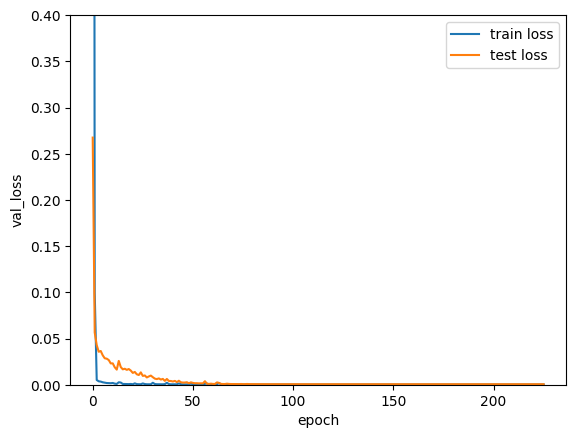

In [ ]:
plt.plot(last10_history.history['loss'], label="train loss")
plt.plot(last10_history.history['val_loss'], label="test loss")
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.ylim([0, 0.4])
plt.legend()
plt.show()

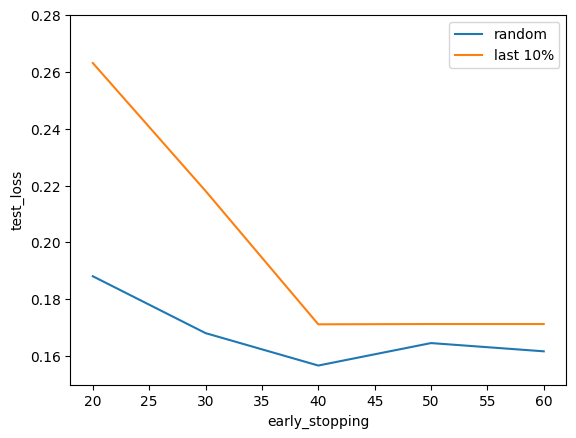

In [ ]:
rmse_random = [0.1881, 0.1681, 0.1567, 0.1646, 0.1617]
rmse_normal = [0.2631, 0.2181, 0.1712, 0.1713, 0.1713]
early_stopping = [20, 30, 40, 50, 60]
plt.plot(early_stopping, rmse_random, label="random")
plt.plot(early_stopping, rmse_normal, label="last 10%")
plt.ylim([0.15, 0.28])
plt.xlabel('early_stopping')
plt.ylabel('test_loss')
plt.legend()
plt.show()

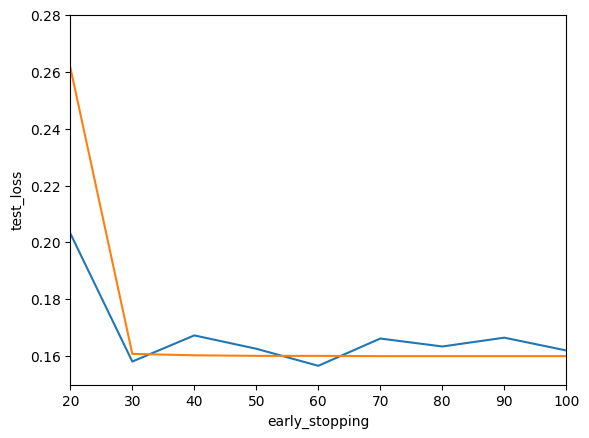

In [ ]:
rmse_random_gap = [0.2032, 0.1581, 0.1673, 0.1626, 0.1566, 0.1662, 0.1634, 0.1665, 0.1620, 0.1676, 0.1611, 0.1624, 0.1627]
rmse_normal_gap = [0.2616, 0.1608, 0.1603, 0.1601, 0.1601, 0.1600, 0.1600, 0.1600, 0.1600, 0.1600, 0.1600, 0.1600, 0.1600]
early_stopping = [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]
plt.plot(early_stopping, rmse_random_gap)
plt.plot(early_stopping, rmse_normal_gap)
plt.ylim([0.15, 0.28])
plt.xlim([20, 100])
plt.xlabel('early_stopping')
plt.ylabel('test_loss')
plt.show()

# part 3 - new features

In [95]:
df_p5198 = pandas.read_csv(path+"old_data_p5198.csv")[["time", "var1", "var2", "kurt1", "kurt2", "entropy1", "entropy2", "entropy change1", "entropy change2", "Shr_stress"]]

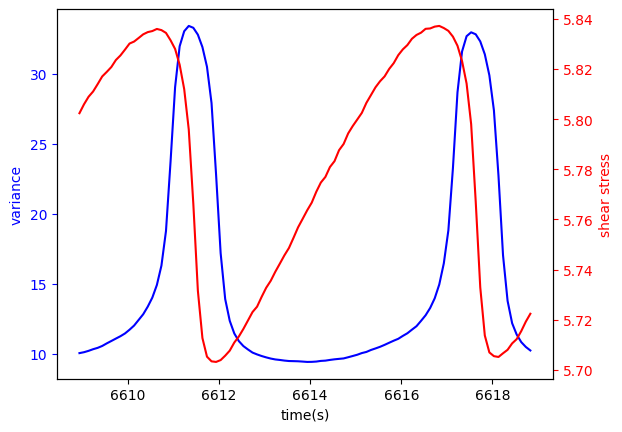

In [97]:
fig, ax1 = plt.subplots()
ax1.plot(df_p5198["time"][100:200], df_p5198["var1"][100:200], 'b-')
ax1.set_xlabel('time(s)')
ax1.set_ylabel('variance', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(df_p5198["time"][100:200], df_p5198["Shr_stress"][100:200], 'r-')
ax2.set_ylabel('shear stress', color='r')
ax2.tick_params('y', colors='r')

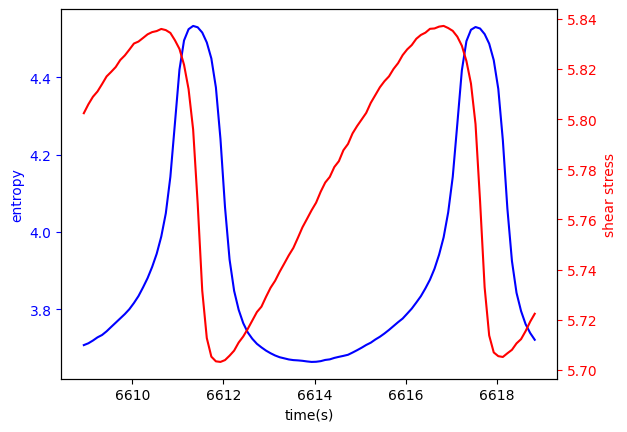

In [98]:
fig, ax1 = plt.subplots()
ax1.plot(df_p5198["time"][100:200], df_p5198["entropy1"][100:200], 'b-')
ax1.set_xlabel('time(s)')
ax1.set_ylabel('entropy', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(df_p5198["time"][100:200], df_p5198["Shr_stress"][100:200], 'r-')
ax2.set_ylabel('shear stress', color='r')
ax2.tick_params('y', colors='r')

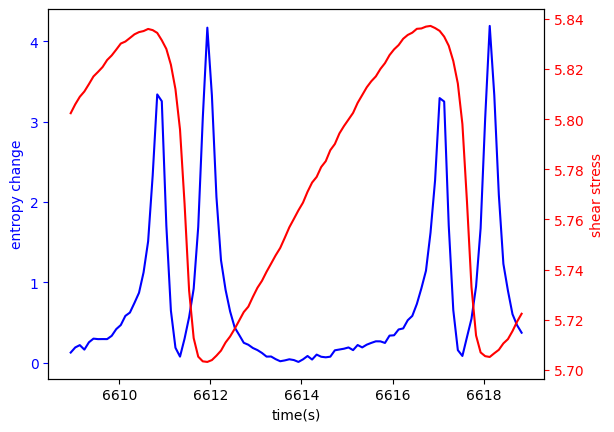

In [99]:
fig, ax1 = plt.subplots()
ax1.plot(df_p5198["time"][100:200], df_p5198["entropy change1"][100:200], 'b-')
ax1.set_xlabel('time(s)')
ax1.set_ylabel('entropy change', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(df_p5198["time"][100:200], df_p5198["Shr_stress"][100:200], 'r-')
ax2.set_ylabel('shear stress', color='r')
ax2.tick_params('y', colors='r')

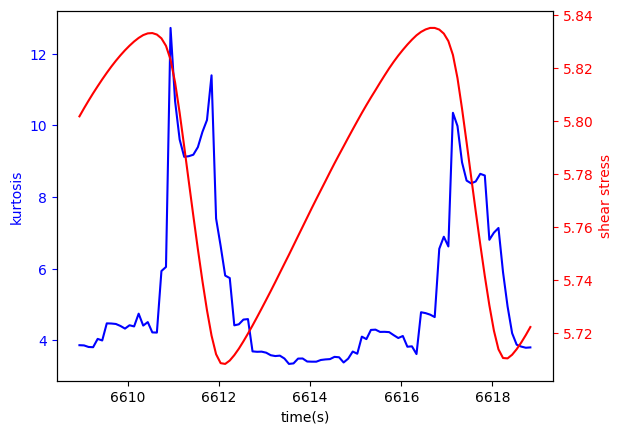

In [28]:
fig, ax1 = plt.subplots()
ax1.plot(df_p5198["Time"][100:200], df_p5198["kurt1"][100:200], 'b-')
ax1.set_xlabel('time(s)')
ax1.set_ylabel('kurtosis', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(df_p5198["Time"][100:200], df_p5198["ShearStress"][100:200], 'r-')
ax2.set_ylabel('shear stress', color='r')
ax2.tick_params('y', colors='r')

In [ ]:
df_p5198_sk = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch1", "Var_Ch2", "skew1", "skew2", "kurt1", "kurt2", "ShearStress"]]
df_p5198_s = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch1", "Var_Ch2", "skew1", "skew2", "ShearStress"]]
df_p5198_k = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch1", "Var_Ch2", "kurt1", "kurt2", "ShearStress"]]
df_p5198_s_left = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch1", "skew1", "ShearStress"]]
df_p5198_k_left = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch1", "kurt1", "ShearStress"]]
df_p5198_s_right = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch2", "skew2", "ShearStress"]]
df_p5198_k_right = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch2", "kurt2", "ShearStress"]]
df_p5198_sk_left = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch1", "skew1", "kurt1", "ShearStress"]]
df_p5198_sk_right = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch2", "skew2", "kurt2", "ShearStress"]]
df_p5198_sk_mix = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch2", "skew1", "kurt2", "ShearStress"]]
df_p5198_v = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch1", "Var_Ch2", "ShearStress"]]
df_p5198_v_left = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch1", "ShearStress"]]
df_p5198_v_right = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch2", "ShearStress"]]
df_p5198_k_only = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["kurt1", "kurt2", "ShearStress"]]

In [ ]:
df_p5198_sk = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch1", "Var_Ch2", "skew1", "skew2", "kurt1", "kurt2", "TimeToStartFailure"]]
df_p5198_s = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch1", "Var_Ch2", "skew1", "skew2", "TimeToStartFailure"]]
df_p5198_k = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch1", "Var_Ch2", "kurt1", "kurt2", "TimeToStartFailure"]]
df_p5198_s_left = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch1", "skew1", "TimeToStartFailure"]]
df_p5198_k_left = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch1", "kurt1", "TimeToStartFailure"]]
df_p5198_s_right = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch2", "skew2", "TimeToStartFailure"]]
df_p5198_k_right = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch2", "kurt2", "TimeToStartFailure"]]
df_p5198_sk_left = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch1", "skew1", "kurt1", "TimeToStartFailure"]]
df_p5198_sk_right = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch2", "skew2", "kurt2", "TimeToStartFailure"]]
df_p5198_sk_mix = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch2", "skew1", "kurt2", "TimeToStartFailure"]]
df_p5198_v = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch1", "Var_Ch2", "TimeToStartFailure"]]
df_p5198_v_left = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch1", "TimeToStartFailure"]]
df_p5198_v_right = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch2", "TimeToStartFailure"]]

In [ ]:
train_percentage = 0.7
val_percentage = 0.1
steps_p5198 = 70
steps_p4679_ss = 2000
steps_p4679_ttf = 1717
steps_p4581 = 70
early_stopping = 40
max_epoch = 250
rand_seed = 1234

In [ ]:
steps = steps_p5198
X_train, y_train, X_test, y_test = train_test_split_func(df_p5198_k_only, train_percentage, steps)

training_set.shape:  (2106, 3)
X_train.shape:  (2036, 70, 2)
y_train.shape:  (2036, 1)
X_test.shape:  (833, 70, 2)
y_test.shape:  (833, 1)


In [ ]:
# last 10% of train as val set
train_X, train_y, val_X, val_y = val_normal_split(X_train, y_train, val_percentage, steps)

# init
# set seed
np.random.seed(1234)
rn.seed(1234)
tf.random.set_seed(1234)
if device == 'cuda':
  os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

class myCallback(tf.keras.callbacks.Callback):
  def __init__(self):
    super().__init__()
    self.testResults=[]
  def on_epoch_end(self, epoch, logs={}):
      restest=model.predict(X_test)
      testResults.append(mean_squared_error(y_test,restest))


testResults=[]
inp = Input(shape=(train_X.shape[1], train_X.shape[2]))
x = BatchNormalization()(inp)
x = LSTM(128,return_sequences=True)(x)
x = Convolution1D(128, (2),activation='relu', padding="same")(x)
x = Convolution1D(84, (2),activation='relu', padding="same")(x)
x = Convolution1D(64, (2),activation='relu', padding="same")(x)

x = Flatten()(x)

x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)


ttf = Dense(1, activation='relu',name='regressor')(x)

model = models.Model(inputs=inp, outputs=ttf)
model.get_weights()

# train
opt = optimizers.Nadam(learning_rate=0.008)

model.compile(optimizer = opt, loss = 'mean_squared_error')

checkpoint_filepath = 'model.hdf5'
cb_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss',mode='min', save_weights_only=True,save_best_only=True)
cb_Early_Stop = EarlyStopping(monitor='val_loss',patience=early_stopping,mode='min', verbose=1)
cb_Reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


callbacks = [cb_checkpoint,cb_Early_Stop,cb_Reduce_LR, myCallback()]

os.environ['PYTHONHASHSEED'] = '0'
session_conf = tf.compat.v1.ConfigProto(allow_soft_placement=True)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

K.set_session(sess)

history=model.fit(train_X, train_y, epochs=max_epoch,callbacks=callbacks, batch_size=256,verbose=1,validation_data=(val_X, val_y))

Epoch 1/120
7/7 [==============================] - 10s 803ms/step - loss: 0.7920 - val_loss: 0.1378 - lr: 0.0080
Epoch 2/120
2/7 [=======>......................] - ETA: 1s - loss: 0.2324

KeyboardInterrupt: ignored

In [ ]:
test_step(model, X_test, y_test, steps)

29/29 [==============================] - 1s 32ms/step
Test r2_score: 0.04982
Test RMSE: 0.27639
8/8 [==============================] - 1s 61ms/step - loss: 0.0787
test loss: 0.07873732596635818


(0.27639120123040306, 0.04982384870577694, 0.07873732596635818)

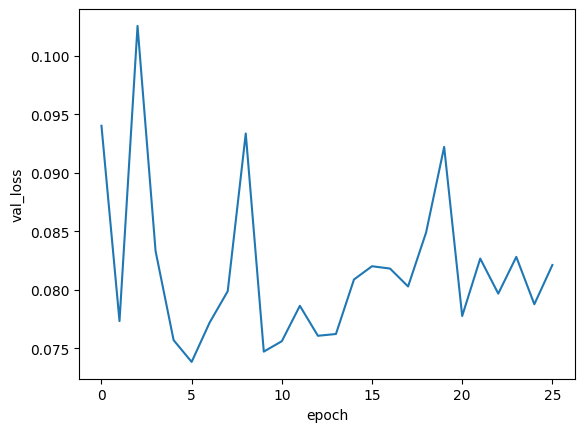

In [ ]:
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.show()

In [ ]:
# 1 time only
training_list = [(df_p5198_sk, "two channels sk"),
          (df_p5198_s, "two channels s"),
          (df_p5198_k, "two channels k"),
          (df_p5198_s_left, "left channel s"),
          (df_p5198_k_left, "left channel k"),
          (df_p5198_s_right, "right channel s"),
          (df_p5198_k_right, "right channel k"),
          (df_p5198_sk_left, "left channel sk"),
          (df_p5198_sk_right, "right channel sk"),
          (df_p5198_v, "two channels v"),
          (df_p5198_v_left, "left channel v"),
          (df_p5198_v_right, "right channel v")]
result_rmse = []
steps = steps_p5198

for (training_set, set_name) in training_list:
  X_train, y_train, X_test, y_test = train_test_split_func(training_set, train_percentage, steps)
  # last 10% of train as val set
  train_X, train_y, val_X, val_y = val_rand_split(X_train, y_train, val_percentage)

  # init
  # set seed
  np.random.seed(rand_seed)
  rn.seed(rand_seed)
  tf.random.set_seed(rand_seed)
  if device == 'cuda':
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

  class myCallback(tf.keras.callbacks.Callback):
    def __init__(self):
      super().__init__()
      self.testResults=[]
    def on_epoch_end(self, epoch, logs={}):
        restest=model.predict(X_test)
        testResults.append(mean_squared_error(y_test,restest))


  testResults=[]
  inp = Input(shape=(train_X.shape[1], train_X.shape[2]))
  x = BatchNormalization()(inp)
  x = LSTM(128,return_sequences=True)(x)
  x = Convolution1D(128, (2),activation='relu', padding="same")(x)
  x = Convolution1D(84, (2),activation='relu', padding="same")(x)
  x = Convolution1D(64, (2),activation='relu', padding="same")(x)

  x = Flatten()(x)

  x = Dense(64, activation="relu")(x)
  x = Dense(32, activation="relu")(x)


  ttf = Dense(1, activation='relu',name='regressor')(x)

  model = models.Model(inputs=inp, outputs=ttf)
  model.get_weights()

  # train
  opt = optimizers.Nadam(learning_rate=0.008)

  model.compile(optimizer = opt, loss = 'mean_squared_error')

  checkpoint_filepath = 'model.hdf5'
  cb_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss',mode='min', save_weights_only=True,save_best_only=True)
  cb_Early_Stop = EarlyStopping(monitor='val_loss',patience=early_stopping,mode='min', verbose=1)
  cb_Reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


  callbacks = [cb_checkpoint,cb_Early_Stop,cb_Reduce_LR, myCallback()]

  os.environ['PYTHONHASHSEED'] = '0'
  session_conf = tf.compat.v1.ConfigProto(allow_soft_placement=True)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

  K.set_session(sess)

  history=model.fit(train_X, train_y, epochs=max_epoch,callbacks=callbacks, batch_size=256,verbose=1,validation_data=(val_X, val_y))

  # store train rmse
  train_rmse, _, _ = test_step(model, train_X, train_y, steps)
  # store test rmse
  test_rmse, _, _ = test_step(model, X_test, y_test, steps)
  result_rmse.append([set_name, round(train_rmse, 4), round(test_rmse, 4)])

training_set.shape:  (2106, 7)
X_train.shape:  (2036, 70, 6)
y_train.shape:  (2036, 1)
X_test.shape:  (833, 70, 6)
y_test.shape:  (833, 1)
Epoch 1/250
8/8 [==============================] - 10s 644ms/step - loss: 3.2212 - val_loss: 0.2711 - lr: 0.0080
Epoch 2/250
8/8 [==============================] - 3s 413ms/step - loss: 0.0837 - val_loss: 0.1354 - lr: 0.0080
Epoch 3/250
8/8 [==============================] - 4s 473ms/step - loss: 0.0246 - val_loss: 0.0804 - lr: 0.0080
Epoch 4/250
8/8 [==============================] - 3s 425ms/step - loss: 0.0190 - val_loss: 0.1027 - lr: 0.0080
Epoch 5/250
8/8 [==============================] - 4s 537ms/step - loss: 0.0181 - val_loss: 0.0939 - lr: 0.0080
Epoch 6/250
8/8 [==============================] - 4s 473ms/step - loss: 0.0167 - val_loss: 0.0968 - lr: 0.0080
Epoch 7/250
8/8 [==============================] - 4s 479ms/step - loss: 0.0164 - val_loss: 0.0799 - lr: 0.0080
Epoch 8/250
8/8 [==============================] - 4s 470ms/step - loss: 0.0

In [ ]:
result_rmse

[['two channels sk', 0.0379, 0.2609],
 ['two channels s', 0.0488, 0.3],
 ['two channels k', 0.047, 0.085],
 ['left channel s', 0.0567, 0.1015],
 ['left channel k', 0.067, 0.1137],
 ['right channel s', 0.0553, 0.2204],
 ['right channel k', 0.0439, 0.0733],
 ['left channel sk', 0.0529, 0.1224],
 ['right channel sk', 0.0568, 0.2952],
 ['two channels v', 0.0552, 0.0744],
 ['left channel v', 0.0511, 0.0782],
 ['right channel v', 0.064, 0.0763]]

In [ ]:
# 10 times
training_list = [(df_p5198_sk, "two channels sk"),
          (df_p5198_s, "two channels s"),
          (df_p5198_k, "two channels k"),
          (df_p5198_v, "two channels v")]
result_rmse = []
steps = steps_p5198

for (training_set, set_name) in training_list:
  X_train, y_train, X_test, y_test = train_test_split_func(training_set, train_percentage, steps)
  # last 10% of train as val set
  train_rmse_list = []
  test_rmse_list = []
  for i in range(10):
    # get val set
    train_X, train_y, val_X, val_y = val_rand_split(X_train, y_train, val_percentage)
    # train
    np.random.seed(1234)
    rn.seed(1234)
    tf.random.set_seed(1234)
    if device == 'cuda':
      os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False

    class myCallback(tf.keras.callbacks.Callback):
      def __init__(self):
        super().__init__()
        self.testResults=[]
      def on_epoch_end(self, epoch, logs={}):
          restest=model.predict(X_test)
          testResults.append(mean_squared_error(y_test,restest))


    testResults=[]
    inp = Input(shape=(train_X.shape[1], train_X.shape[2]))
    x = BatchNormalization()(inp)
    x = LSTM(128,return_sequences=True)(x)
    x = Convolution1D(128, (2),activation='relu', padding="same")(x)
    x = Convolution1D(84, (2),activation='relu', padding="same")(x)
    x = Convolution1D(64, (2),activation='relu', padding="same")(x)

    x = Flatten()(x)

    x = Dense(64, activation="relu")(x)
    x = Dense(32, activation="relu")(x)


    ttf = Dense(1, activation='relu',name='regressor')(x)

    model = models.Model(inputs=inp, outputs=ttf)

    opt = optimizers.Nadam(learning_rate=0.008)

    model.compile(optimizer = opt, loss = 'mean_squared_error')

    checkpoint_filepath = 'model.hdf5'
    cb_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss',mode='min', save_weights_only=True,save_best_only=True)
    cb_Early_Stop=EarlyStopping(monitor='val_loss',patience=early_stopping,mode='min', verbose=1)
    cb_Reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


    callbacks = [cb_checkpoint,cb_Early_Stop,cb_Reduce_LR, myCallback()]

    os.environ['PYTHONHASHSEED'] = '0'
    session_conf = tf.compat.v1.ConfigProto(allow_soft_placement=True)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

    K.set_session(sess)

    history=model.fit(train_X, train_y, epochs=max_epoch,callbacks=callbacks, batch_size=256,verbose=1,validation_data=(val_X, val_y))

    # store train rmse
    train_rmse, _, _ = test_step(model, train_X, train_y, steps)

    # test
    test_rmse, _, _ = test_step(model, X_test, y_test, steps)
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

  result_rmse.append([set_name, round(np.mean(train_rmse_list), 4), round(np.std(train_rmse_list), 4), round(np.mean(test_rmse_list), 4), round(np.std(test_rmse_list), 4)])

流式输出内容被截断，只能显示最后 5000 行内容。
8/8 [==============================] - 3s 429ms/step - loss: 0.0188 - val_loss: 0.0388 - lr: 0.0080
Epoch 8/250
8/8 [==============================] - 4s 470ms/step - loss: 0.0186 - val_loss: 0.0547 - lr: 0.0080
Epoch 9/250
8/8 [==============================] - 4s 465ms/step - loss: 0.0164 - val_loss: 0.0499 - lr: 0.0080
Epoch 10/250
8/8 [==============================] - 4s 463ms/step - loss: 0.0162 - val_loss: 0.0515 - lr: 0.0080
Epoch 11/250
8/8 [==============================] - 3s 430ms/step - loss: 0.0142 - val_loss: 0.0562 - lr: 0.0080
Epoch 12/250
8/8 [==============================] - 3s 422ms/step - loss: 0.0134 - val_loss: 0.0689 - lr: 0.0080
Epoch 13/250
8/8 [==============================] - 4s 463ms/step - loss: 0.0118 - val_loss: 0.0715 - lr: 0.0040
Epoch 14/250
8/8 [==============================] - 4s 481ms/step - loss: 0.0099 - val_loss: 0.0714 - lr: 0.0040
Epoch 15/250
8/8 [==============================] - 3s 416ms/step - loss: 0.0098 - v

In [ ]:
result_rmse

[['two channels sk', 0.0362, 0.0134, 0.4287, 0.1679],
 ['two channels s', 0.0432, 0.0157, 0.3199, 0.0781],
 ['two channels k', 0.0472, 0.0092, 0.1037, 0.0101],
 ['two channels v', 0.0625, 0.0099, 0.0786, 0.0077]]

In [ ]:
df_p5198_v = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch1", "Var_Ch2", "ShearStress"]]
df_p5198_ec = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["entropy change1", "entropy change2", "ShearStress"]]
df_p5198_vec = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch1", "Var_Ch2", "entropy change1", "entropy change2", "ShearStress"]]
df_p5198_e = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["entropy1", "entropy2", "ShearStress"]]
df_p5198_ve = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch1", "Var_Ch2", "entropy1", "entropy2", "ShearStress"]]
df_p5198_eec = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["entropy1", "entropy2", "entropy change1", "entropy change2", "ShearStress"]]
df_p5198_veec = pandas.read_csv(path+"newDF_p5198_with_skew_kurt.csv")[["Var_Ch1", "Var_Ch2", "entropy1", "entropy2", "entropy change1", "entropy change2", "ShearStress"]]

In [ ]:
training_list = [(df_p5198_v, "var"),
          (df_p5198_ec, "entropy change"),
          (df_p5198_vec, "var and entropy change"),
          (df_p5198_e, "entropy"),
          (df_p5198_ve, "var and entropy"),
          (df_p5198_eec, "entropy and entropy change"),
          (df_p5198_veec, "all three")]
result_rmse = []
steps = steps_p5198

for (training_set, set_name) in training_list:
  X_train, y_train, X_test, y_test = train_test_split_func(training_set, train_percentage, steps)
  # last 10% of train as val set
  train_X, train_y, val_X, val_y = val_normal_split(X_train, y_train, val_percentage, steps)

  # init
  # set seed
  np.random.seed(rand_seed)
  rn.seed(rand_seed)
  tf.random.set_seed(rand_seed)
  if device == 'cuda':
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

  class myCallback(tf.keras.callbacks.Callback):
    def __init__(self):
      super().__init__()
      self.testResults=[]
    def on_epoch_end(self, epoch, logs={}):
        restest=model.predict(X_test)
        testResults.append(mean_squared_error(y_test,restest))


  testResults=[]
  inp = Input(shape=(train_X.shape[1], train_X.shape[2]))
  x = BatchNormalization()(inp)
  x = LSTM(128,return_sequences=True)(x)
  x = Convolution1D(128, (2),activation='relu', padding="same")(x)
  x = Convolution1D(84, (2),activation='relu', padding="same")(x)
  x = Convolution1D(64, (2),activation='relu', padding="same")(x)

  x = Flatten()(x)

  x = Dense(64, activation="relu")(x)
  x = Dense(32, activation="relu")(x)


  ttf = Dense(1, activation='relu',name='regressor')(x)

  model = models.Model(inputs=inp, outputs=ttf)
  model.get_weights()

  # train
  opt = optimizers.Nadam(learning_rate=0.008)

  model.compile(optimizer = opt, loss = 'mean_squared_error')

  checkpoint_filepath = 'model.hdf5'
  cb_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss',mode='min', save_weights_only=True,save_best_only=True)
  cb_Early_Stop = EarlyStopping(monitor='val_loss',patience=early_stopping,mode='min', verbose=1)
  cb_Reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


  # callbacks = [cb_checkpoint,cb_Early_Stop,cb_Reduce_LR, myCallback()]
  callbacks = [cb_checkpoint,cb_Reduce_LR, myCallback()]

  os.environ['PYTHONHASHSEED'] = '0'
  session_conf = tf.compat.v1.ConfigProto(allow_soft_placement=True)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

  K.set_session(sess)

  history=model.fit(train_X, train_y, epochs=max_epoch,callbacks=callbacks, batch_size=256,verbose=1,validation_data=(val_X, val_y))

  # store train rmse
  train_rmse, _, _ = test_step(model, train_X, train_y, steps)
  # store test rmse
  test_rmse, _, _ = test_step(model, X_test, y_test, steps)
  result_rmse.append([set_name, round(train_rmse, 4), round(test_rmse, 4)])

training_set.shape:  (2106, 3)
X_train.shape:  (2036, 70, 2)
y_train.shape:  (2036, 1)
X_test.shape:  (833, 70, 2)
y_test.shape:  (833, 1)
Epoch 1/200
7/7 [==============================] - 9s 647ms/step - loss: 2.6226 - val_loss: 0.2675 - lr: 0.0080
Epoch 2/200
7/7 [==============================] - 3s 466ms/step - loss: 0.1001 - val_loss: 0.0546 - lr: 0.0080
Epoch 3/200
7/7 [==============================] - 4s 592ms/step - loss: 0.0049 - val_loss: 0.0438 - lr: 0.0080
Epoch 4/200
7/7 [==============================] - 4s 530ms/step - loss: 0.0037 - val_loss: 0.0363 - lr: 0.0080
Epoch 5/200
7/7 [==============================] - 3s 526ms/step - loss: 0.0034 - val_loss: 0.0370 - lr: 0.0080
Epoch 6/200
7/7 [==============================] - 3s 527ms/step - loss: 0.0028 - val_loss: 0.0328 - lr: 0.0080
Epoch 7/200
7/7 [==============================] - 4s 565ms/step - loss: 0.0024 - val_loss: 0.0300 - lr: 0.0080
Epoch 8/200
7/7 [==============================] - 3s 471ms/step - loss: 0.00

In [ ]:
result_rmse

[['var', 0.0143, 0.0225],
 ['entropy change', 0.0408, 0.0993],
 ['var and entropy change', 0.009, 0.0374],
 ['entropy', 0.0407, 0.0896],
 ['var and entropy', 0.0236, 0.0531],
 ['entropy and entropy change', 0.0187, 0.1015],
 ['all three', 0.0195, 0.0514]]

In [ ]:
result_df = pandas.DataFrame(result_rmse, columns=["experience", "train rmse", "test rmse"])
result_df.to_csv('entropy_p5198_without_early_stopping.csv', index=False)

## new data p5198

In [8]:
# use the right, new data
df_p5198_v = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "var2", "Shr_stress"]]
df_p5198_k = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "var2", "kurt1", "kurt2", "Shr_stress"]]
df_p5198_e = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "var2", "entropy1", "entropy2", "Shr_stress"]]
df_p5198_ec = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "var2", "entropy change1", "entropy change2", "Shr_stress"]]
df_p5198_ke = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "var2", "kurt1", "kurt2", "entropy1", "entropy2", "Shr_stress"]]
df_p5198_kec = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "var2", "kurt1", "kurt2", "entropy change1", "entropy change2", "Shr_stress"]]
df_p5198_eec = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "var2", "entropy1", "entropy2", "entropy change1", "entropy change2", "Shr_stress"]]
df_p5198_keec = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "var2", "kurt1", "kurt2", "entropy1", "entropy2", "entropy change1", "entropy change2", "Shr_stress"]]

# left channel
df_p5198_v_left = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "Shr_stress"]]
df_p5198_k_left = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "kurt1", "Shr_stress"]]
df_p5198_e_left = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "entropy1", "Shr_stress"]]
df_p5198_ec_left = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "entropy change1", "Shr_stress"]]
df_p5198_ke_left = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "kurt1", "entropy1", "Shr_stress"]]
df_p5198_kec_left = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "kurt1", "entropy change1", "Shr_stress"]]
df_p5198_eec_left = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "entropy1", "entropy change1", "Shr_stress"]]
df_p5198_keec_left = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "kurt1", "entropy1", "entropy change1", "Shr_stress"]]

# right channel
df_p5198_v_right = pandas.read_csv(path+"old_data_p5198.csv")[["var2", "Shr_stress"]]
df_p5198_k_right = pandas.read_csv(path+"old_data_p5198.csv")[["var2", "kurt2", "Shr_stress"]]
df_p5198_e_right = pandas.read_csv(path+"old_data_p5198.csv")[["var2", "entropy2", "Shr_stress"]]
df_p5198_ec_right = pandas.read_csv(path+"old_data_p5198.csv")[["var2", "entropy change2", "Shr_stress"]]
df_p5198_ke_right = pandas.read_csv(path+"old_data_p5198.csv")[["var2", "kurt2", "entropy2", "Shr_stress"]]
df_p5198_kec_right = pandas.read_csv(path+"old_data_p5198.csv")[["var2", "kurt2", "entropy change2", "Shr_stress"]]
df_p5198_eec_right = pandas.read_csv(path+"old_data_p5198.csv")[["var2", "entropy2", "entropy change2", "Shr_stress"]]
df_p5198_keec_right = pandas.read_csv(path+"old_data_p5198.csv")[["var2", "kurt2", "entropy2", "entropy change2", "Shr_stress"]]

In [348]:
# use the right, new data
df_p5198_v = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "var2", "TTsF"]]
df_p5198_k = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "var2", "kurt1", "kurt2", "TTsF"]]
df_p5198_e = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "var2", "entropy1", "entropy2", "TTsF"]]
df_p5198_ec = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "var2", "entropy change1", "entropy change2", "TTsF"]]
df_p5198_ke = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "var2", "kurt1", "kurt2", "entropy1", "entropy2", "TTsF"]]
df_p5198_kec = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "var2", "kurt1", "kurt2", "entropy change1", "entropy change2", "TTsF"]]
df_p5198_eec = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "var2", "entropy1", "entropy2", "entropy change1", "entropy change2", "TTsF"]]
df_p5198_keec = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "var2", "kurt1", "kurt2", "entropy1", "entropy2", "entropy change1", "entropy change2", "TTsF"]]

# left channel
df_p5198_v_left = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "TTsF"]]
df_p5198_k_left = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "kurt1", "TTsF"]]
df_p5198_e_left = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "entropy1", "TTsF"]]
df_p5198_ec_left = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "entropy change1", "TTsF"]]
df_p5198_ke_left = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "kurt1", "entropy1", "TTsF"]]
df_p5198_kec_left = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "kurt1", "entropy change1", "TTsF"]]
df_p5198_eec_left = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "entropy1", "entropy change1", "TTsF"]]
df_p5198_keec_left = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "kurt1", "entropy1", "entropy change1", "TTsF"]]

# right channel
df_p5198_v_right = pandas.read_csv(path+"old_data_p5198.csv")[["var2", "TTsF"]]
df_p5198_k_right = pandas.read_csv(path+"old_data_p5198.csv")[["var2", "kurt2", "TTsF"]]
df_p5198_e_right = pandas.read_csv(path+"old_data_p5198.csv")[["var2", "entropy2", "TTsF"]]
df_p5198_ec_right = pandas.read_csv(path+"old_data_p5198.csv")[["var2", "entropy change2", "TTsF"]]
df_p5198_ke_right = pandas.read_csv(path+"old_data_p5198.csv")[["var2", "kurt2", "entropy2", "TTsF"]]
df_p5198_kec_right = pandas.read_csv(path+"old_data_p5198.csv")[["var2", "kurt2", "entropy change2", "TTsF"]]
df_p5198_eec_right = pandas.read_csv(path+"old_data_p5198.csv")[["var2", "entropy2", "entropy change2", "TTsF"]]
df_p5198_keec_right = pandas.read_csv(path+"old_data_p5198.csv")[["var2", "kurt2", "entropy2", "entropy change2", "TTsF"]]

In [349]:
# 1 time only
training_list = [(df_p5198_v, "two channels v"),
          (df_p5198_k, "two channels k"),
          (df_p5198_e, "two channels e"),
          (df_p5198_ec, "two channel ec"),
          (df_p5198_ke, "two channel ke"),
          (df_p5198_kec, "two channel kec"),
          (df_p5198_eec, "two channel eec"),
          (df_p5198_keec, "two channel keec"),
          (df_p5198_v_left, "left channels v"),
          (df_p5198_k_left, "left channels k"),
          (df_p5198_e_left, "left channels e"),
          (df_p5198_ec_left, "left channel ec"),
          (df_p5198_ke_left, "left channel ke"),
          (df_p5198_kec_left, "left channel kec"),
          (df_p5198_eec_left, "left channel eec"),
          (df_p5198_keec_left, "left channel keec"),
          (df_p5198_v_right, "right channels v"),
          (df_p5198_k_right, "right channels k"),
          (df_p5198_e_right, "right channels e"),
          (df_p5198_ec_right, "right channel ec"),
          (df_p5198_ke_right, "right channel ke"),
          (df_p5198_kec_right, "right channel kec"),
          (df_p5198_eec_right, "right channel eec"),
          (df_p5198_keec_right, "right channel keec")]
result_rmse = []
steps = 70
train_percentage = 0.7
val_percentage = 0.1
rand_seed = 1234

for (training_set, set_name) in training_list:
  X_train, y_train, X_test, y_test = train_test_split_func(training_set, train_percentage, steps)
  # last 10% of train as val set
  train_X, train_y, val_X, val_y = val_rand_split(X_train, y_train, val_percentage)

  # init
  # set seed
  np.random.seed(rand_seed)
  rn.seed(rand_seed)
  tf.random.set_seed(rand_seed)
  if device == 'cuda':
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

  class myCallback(tf.keras.callbacks.Callback):
    def __init__(self):
      super().__init__()
      self.testResults=[]
    def on_epoch_end(self, epoch, logs={}):
        restest=model.predict(X_test)
        testResults.append(mean_squared_error(y_test,restest))


  testResults=[]
  inp = Input(shape=(train_X.shape[1], train_X.shape[2]))
  x = BatchNormalization()(inp)
  x = LSTM(128,return_sequences=True)(x)
  x = Convolution1D(128, (2),activation='relu', padding="same")(x)
  x = Convolution1D(84, (2),activation='relu', padding="same")(x)
  x = Convolution1D(64, (2),activation='relu', padding="same")(x)

  x = Flatten()(x)

  x = Dense(64, activation="relu")(x)
  x = Dense(32, activation="relu")(x)


  ttf = Dense(1, activation='relu',name='regressor')(x)

  model = models.Model(inputs=inp, outputs=ttf)
  model.get_weights()

  # train
  opt = optimizers.Nadam(learning_rate=0.008)

  model.compile(optimizer = opt, loss = 'mean_squared_error')

  checkpoint_filepath = 'model.hdf5'
  cb_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss',mode='min', save_weights_only=True,save_best_only=True)
  cb_Early_Stop = EarlyStopping(monitor='val_loss',patience=early_stopping,mode='min', verbose=1)
  cb_Reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


  callbacks = [cb_checkpoint,cb_Early_Stop,cb_Reduce_LR, myCallback()]

  os.environ['PYTHONHASHSEED'] = '0'
  session_conf = tf.compat.v1.ConfigProto(allow_soft_placement=True)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

  K.set_session(sess)

  history=model.fit(train_X, train_y, epochs=max_epoch,callbacks=callbacks, batch_size=256,verbose=1,validation_data=(val_X, val_y))

  # store train rmse
  train_rmse, train_r2, _ = test_step(model, train_X, train_y, steps)
  # store test rmse
  test_rmse, test_r2, _ = test_step(model, X_test, y_test, steps)
  result_rmse.append([set_name, round(train_rmse, 4), round(train_r2, 4), round(test_rmse, 4), round(test_r2, 4)])

流式输出内容被截断，只能显示最后 5000 行内容。
8/8 [==============================] - 3s 327ms/step - loss: 0.0039 - val_loss: 0.0056 - lr: 3.1250e-05
Epoch 100/250
8/8 [==============================] - 3s 331ms/step - loss: 0.0037 - val_loss: 0.0056 - lr: 3.1250e-05
Epoch 101/250
8/8 [==============================] - 3s 332ms/step - loss: 0.0037 - val_loss: 0.0056 - lr: 3.1250e-05
Epoch 102/250
8/8 [==============================] - 2s 320ms/step - loss: 0.0038 - val_loss: 0.0056 - lr: 3.1250e-05
Epoch 103/250
8/8 [==============================] - 2s 324ms/step - loss: 0.0038 - val_loss: 0.0056 - lr: 3.1250e-05
Epoch 104/250
8/8 [==============================] - 3s 397ms/step - loss: 0.0037 - val_loss: 0.0056 - lr: 1.5625e-05
Epoch 105/250
8/8 [==============================] - 3s 339ms/step - loss: 0.0038 - val_loss: 0.0056 - lr: 1.5625e-05
Epoch 106/250
8/8 [==============================] - 3s 417ms/step - loss: 0.0037 - val_loss: 0.0056 - lr: 1.5625e-05
Epoch 107/250
8/8 [========================

In [350]:
result_rmse

[['two channels v', 0.0616, 0.9498, 0.0947, 0.8915],
 ['two channels k', 0.0424, 0.9765, 0.1489, 0.7316],
 ['two channels e', 0.0633, 0.9479, 0.095, 0.8908],
 ['two channel ec', 0.0567, 0.9583, 0.0947, 0.8914],
 ['two channel ke', 0.0724, 0.9314, 0.1094, 0.8552],
 ['two channel kec', 0.0418, 0.9772, 0.1138, 0.8433],
 ['two channel eec', 0.0582, 0.9558, 0.0957, 0.8893],
 ['two channel keec', 0.04, 0.9791, 0.1175, 0.8329],
 ['left channels v', 0.0634, 0.9476, 0.0949, 0.891],
 ['left channels k', 0.0527, 0.9643, 0.1635, 0.6766],
 ['left channels e', 0.0622, 0.9496, 0.1008, 0.8771],
 ['left channel ec', 0.0489, 0.9686, 0.1083, 0.8581],
 ['left channel ke', 0.0449, 0.9737, 0.1147, 0.8409],
 ['left channel kec', 0.0465, 0.9719, 0.1108, 0.8515],
 ['left channel eec', 0.0416, 0.9774, 0.1006, 0.8776],
 ['left channel keec', 0.0458, 0.9728, 0.1261, 0.8076],
 ['right channels v', 0.0623, 0.949, 0.0966, 0.8871],
 ['right channels k', 0.0636, 0.9471, 0.0944, 0.8922],
 ['right channels e', 0.067, 0.

In [ ]:
X_train, y_train, X_test, y_test = train_test_split_func(training_set, train_percentage, steps)
  # last 10% of train as val set
  train_X, train_y, val_X, val_y = val_rand_split(X_train, y_train, val_percentage)

  # init
  # set seed
  np.random.seed(rand_seed)
  rn.seed(rand_seed)
  tf.random.set_seed(rand_seed)
  if device == 'cuda':
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

  class myCallback(tf.keras.callbacks.Callback):
    def __init__(self):
      super().__init__()
      self.testResults=[]
    def on_epoch_end(self, epoch, logs={}):
        restest=model.predict(X_test)
        testResults.append(mean_squared_error(y_test,restest))


  testResults=[]
  inp = Input(shape=(train_X.shape[1], train_X.shape[2]))
  x = BatchNormalization()(inp)
  x = LSTM(128,return_sequences=True)(x)
  x = Convolution1D(128, (2),activation='relu', padding="same")(x)
  x = Convolution1D(84, (2),activation='relu', padding="same")(x)
  x = Convolution1D(64, (2),activation='relu', padding="same")(x)

  x = Flatten()(x)

  x = Dense(64, activation="relu")(x)
  x = Dense(32, activation="relu")(x)


  ttf = Dense(1, activation='relu',name='regressor')(x)

  model = models.Model(inputs=inp, outputs=ttf)
  model.get_weights()

  # train
  opt = optimizers.Nadam(learning_rate=0.008)

  model.compile(optimizer = opt, loss = 'mean_squared_error')

  checkpoint_filepath = 'model.hdf5'
  cb_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss',mode='min', save_weights_only=True,save_best_only=True)
  cb_Early_Stop = EarlyStopping(monitor='val_loss',patience=early_stopping,mode='min', verbose=1)
  cb_Reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


  callbacks = [cb_checkpoint,cb_Early_Stop,cb_Reduce_LR, myCallback()]

  os.environ['PYTHONHASHSEED'] = '0'
  session_conf = tf.compat.v1.ConfigProto(allow_soft_placement=True)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

  K.set_session(sess)

  history=model.fit(train_X, train_y, epochs=max_epoch,callbacks=callbacks, batch_size=256,verbose=1,validation_data=(val_X, val_y))

  # store train rmse
  train_rmse, train_r2, _ = test_step(model, train_X, train_y, steps)
  # store test rmse
  test_rmse, test_r2, _ = test_step(model, X_test, y_test, steps)
  result_rmse.append([set_name, round(train_rmse, 4), round(train_r2, 4), round(test_rmse, 4), round(test_r2, 4)])

## new data p4581

In [26]:
# use the right, new data
df_p4581_v = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "var2", "Shr_stress"]]
df_p4581_k = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "var2", "kurt1", "kurt2", "Shr_stress"]]
df_p4581_e = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "var2", "entropy1", "entropy2", "Shr_stress"]]
df_p4581_ec = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "var2", "entropy change1", "entropy change2", "Shr_stress"]]
df_p4581_ke = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "var2", "kurt1", "kurt2", "entropy1", "entropy2", "Shr_stress"]]
df_p4581_kec = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "var2", "kurt1", "kurt2", "entropy change1", "entropy change2", "Shr_stress"]]
df_p4581_eec = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "var2", "entropy1", "entropy2", "entropy change1", "entropy change2", "Shr_stress"]]
df_p4581_keec = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "var2", "kurt1", "kurt2", "entropy1", "entropy2", "entropy change1", "entropy change2", "Shr_stress"]]

# left channel
df_p4581_v_left = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "Shr_stress"]]
df_p4581_k_left = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "kurt1", "Shr_stress"]]
df_p4581_e_left = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "entropy1", "Shr_stress"]]
df_p4581_ec_left = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "entropy change1", "Shr_stress"]]
df_p4581_ke_left = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "kurt1", "entropy1", "Shr_stress"]]
df_p4581_kec_left = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "kurt1", "entropy change1", "Shr_stress"]]
df_p4581_eec_left = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "entropy1", "entropy change1", "Shr_stress"]]
df_p4581_keec_left = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "kurt1", "entropy1", "entropy change1", "Shr_stress"]]

# right channel
df_p4581_v_right = pandas.read_csv(path+"old_data_p4581.csv")[["var2", "Shr_stress"]]
df_p4581_k_right = pandas.read_csv(path+"old_data_p4581.csv")[["var2", "kurt2", "Shr_stress"]]
df_p4581_e_right = pandas.read_csv(path+"old_data_p4581.csv")[["var2", "entropy2", "Shr_stress"]]
df_p4581_ec_right = pandas.read_csv(path+"old_data_p4581.csv")[["var2", "entropy change2", "Shr_stress"]]
df_p4581_ke_right = pandas.read_csv(path+"old_data_p4581.csv")[["var2", "kurt2", "entropy2", "Shr_stress"]]
df_p4581_kec_right = pandas.read_csv(path+"old_data_p4581.csv")[["var2", "kurt2", "entropy change2", "Shr_stress"]]
df_p4581_eec_right = pandas.read_csv(path+"old_data_p4581.csv")[["var2", "entropy2", "entropy change2", "Shr_stress"]]
df_p4581_keec_right = pandas.read_csv(path+"old_data_p4581.csv")[["var2", "kurt2", "entropy2", "entropy change2", "Shr_stress"]]

In [19]:
# use the right, new data
df_p4581_v = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "var2", "TTsF"]]
df_p4581_k = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "var2", "kurt1", "kurt2", "TTsF"]]
df_p4581_e = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "var2", "entropy1", "entropy2", "TTsF"]]
df_p4581_ec = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "var2", "entropy change1", "entropy change2", "TTsF"]]
df_p4581_ke = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "var2", "kurt1", "kurt2", "entropy1", "entropy2", "TTsF"]]
df_p4581_kec = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "var2", "kurt1", "kurt2", "entropy change1", "entropy change2", "TTsF"]]
df_p4581_eec = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "var2", "entropy1", "entropy2", "entropy change1", "entropy change2", "TTsF"]]
df_p4581_keec = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "var2", "kurt1", "kurt2", "entropy1", "entropy2", "entropy change1", "entropy change2", "TTsF"]]

# left channel
df_p4581_v_left = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "TTsF"]]
df_p4581_k_left = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "kurt1", "TTsF"]]
df_p4581_e_left = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "entropy1", "TTsF"]]
df_p4581_ec_left = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "entropy change1", "TTsF"]]
df_p4581_ke_left = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "kurt1", "entropy1", "TTsF"]]
df_p4581_kec_left = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "kurt1", "entropy change1", "TTsF"]]
df_p4581_eec_left = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "entropy1", "entropy change1", "TTsF"]]
df_p4581_keec_left = pandas.read_csv(path+"old_data_p4581.csv")[["var1", "kurt1", "entropy1", "entropy change1", "TTsF"]]

# right channel
df_p4581_v_right = pandas.read_csv(path+"old_data_p4581.csv")[["var2", "TTsF"]]
df_p4581_k_right = pandas.read_csv(path+"old_data_p4581.csv")[["var2", "kurt2", "TTsF"]]
df_p4581_e_right = pandas.read_csv(path+"old_data_p4581.csv")[["var2", "entropy2", "TTsF"]]
df_p4581_ec_right = pandas.read_csv(path+"old_data_p4581.csv")[["var2", "entropy change2", "TTsF"]]
df_p4581_ke_right = pandas.read_csv(path+"old_data_p4581.csv")[["var2", "kurt2", "entropy2", "TTsF"]]
df_p4581_kec_right = pandas.read_csv(path+"old_data_p4581.csv")[["var2", "kurt2", "entropy change2", "TTsF"]]
df_p4581_eec_right = pandas.read_csv(path+"old_data_p4581.csv")[["var2", "entropy2", "entropy change2", "TTsF"]]
df_p4581_keec_right = pandas.read_csv(path+"old_data_p4581.csv")[["var2", "kurt2", "entropy2", "entropy change2", "TTsF"]]

In [63]:
# 1 time only
training_list = [(df_p4581_v, "two channels v"),
          (df_p4581_k, "two channels k"),
          (df_p4581_e, "two channels e"),
          (df_p4581_ec, "two channel ec"),
          (df_p4581_ke, "two channel ke"),
          (df_p4581_kec, "two channel kec"),
          (df_p4581_eec, "two channel eec"),
          (df_p4581_keec, "two channel keec"),
          (df_p4581_v_left, "left channels v"),
          (df_p4581_k_left, "left channels k"),
          (df_p4581_e_left, "left channels e"),
          (df_p4581_ec_left, "left channel ec"),
          (df_p4581_ke_left, "left channel ke"),
          (df_p4581_kec_left, "left channel kec"),
          (df_p4581_eec_left, "left channel eec"),
          (df_p4581_keec_left, "left channel keec"),
          (df_p4581_v_right, "right channels v"),
          (df_p4581_k_right, "right channels k"),
          (df_p4581_e_right, "right channels e"),
          (df_p4581_ec_right, "right channel ec"),
          (df_p4581_ke_right, "right channel ke"),
          (df_p4581_kec_right, "right channel kec"),
          (df_p4581_eec_right, "right channel eec"),
          (df_p4581_keec_right, "right channel keec")]
result_rmse = []
steps = 70
train_percentage = 0.7
val_percentage = 0.1
rand_seed = 1234

for (training_set, set_name) in training_list:
  X_train, y_train, X_test, y_test = train_test_split_func(training_set, train_percentage, steps)
  # last 10% of train as val set
  train_X, train_y, val_X, val_y = val_rand_split(X_train, y_train, val_percentage)

  # init
  # set seed
  np.random.seed(rand_seed)
  rn.seed(rand_seed)
  tf.random.set_seed(rand_seed)
  if device == 'cuda':
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

  class myCallback(tf.keras.callbacks.Callback):
    def __init__(self):
      super().__init__()
      self.testResults=[]
    def on_epoch_end(self, epoch, logs={}):
        restest=model.predict(X_test)
        testResults.append(mean_squared_error(y_test,restest))


  testResults=[]
  inp = Input(shape=(train_X.shape[1], train_X.shape[2]))
  x = BatchNormalization()(inp)
  x = LSTM(128,return_sequences=True)(x)
  x = Convolution1D(128, (2),activation='relu', padding="same")(x)
  x = Convolution1D(84, (2),activation='relu', padding="same")(x)
  x = Convolution1D(64, (2),activation='relu', padding="same")(x)

  x = Flatten()(x)

  x = Dense(64, activation="relu")(x)
  x = Dense(32, activation="relu")(x)


  ttf = Dense(1, activation='relu',name='regressor')(x)

  model = models.Model(inputs=inp, outputs=ttf)
  model.get_weights()

  # train
  opt = optimizers.Nadam(learning_rate=0.008)

  model.compile(optimizer = opt, loss = 'mean_squared_error')

  checkpoint_filepath = 'model.hdf5'
  cb_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss',mode='min', save_weights_only=True,save_best_only=True)
  cb_Early_Stop = EarlyStopping(monitor='val_loss',patience=early_stopping,mode='min', verbose=1)
  cb_Reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


  callbacks = [cb_checkpoint,cb_Early_Stop,cb_Reduce_LR, myCallback()]

  os.environ['PYTHONHASHSEED'] = '0'
  session_conf = tf.compat.v1.ConfigProto(allow_soft_placement=True)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

  K.set_session(sess)

  history=model.fit(train_X, train_y, epochs=max_epoch,callbacks=callbacks, batch_size=256,verbose=1,validation_data=(val_X, val_y))

  # store train rmse
  train_rmse, train_r2, _ = test_step(model, train_X, train_y, steps)
  # store test rmse
  test_rmse, test_r2, _ = test_step(model, X_test, y_test, steps)
  result_rmse.append([set_name, round(train_rmse, 4), round(train_r2, 4), round(test_rmse, 4), round(test_r2, 4)])

流式输出内容被截断，只能显示最后 5000 行内容。
8/8 [==============================] - 3s 381ms/step - loss: 0.0067 - val_loss: 0.0069 - lr: 4.7684e-10
Epoch 184/250
8/8 [==============================] - 3s 377ms/step - loss: 0.0067 - val_loss: 0.0069 - lr: 4.7684e-10
Epoch 185/250
8/8 [==============================] - 3s 390ms/step - loss: 0.0068 - val_loss: 0.0069 - lr: 4.7684e-10
Epoch 186/250
8/8 [==============================] - 2s 298ms/step - loss: 0.0067 - val_loss: 0.0069 - lr: 4.7684e-10
Epoch 187/250
8/8 [==============================] - 3s 376ms/step - loss: 0.0067 - val_loss: 0.0069 - lr: 2.3842e-10
Epoch 188/250
8/8 [==============================] - 3s 380ms/step - loss: 0.0068 - val_loss: 0.0069 - lr: 2.3842e-10
Epoch 189/250
8/8 [==============================] - 3s 384ms/step - loss: 0.0069 - val_loss: 0.0069 - lr: 2.3842e-10
Epoch 190/250
8/8 [==============================] - 2s 303ms/step - loss: 0.0067 - val_loss: 0.0069 - lr: 2.3842e-10
Epoch 191/250
8/8 [========================

In [64]:
result_rmse

[['two channels v', 0.1115, 0.8076, 0.0955, 0.8606],
 ['two channels k', 0.0568, 0.9497, 0.1331, 0.729],
 ['two channels e', 0.0858, 0.8888, 0.1034, 0.8366],
 ['two channel ec', 0.1011, 0.8435, 0.091, 0.8733],
 ['two channel ke', 0.0543, 0.9547, 0.128, 0.7496],
 ['two channel kec', 0.0416, 0.9735, 0.1303, 0.7403],
 ['two channel eec', 0.0971, 0.8549, 0.101, 0.844],
 ['two channel keec', 0.0592, 0.9458, 0.1285, 0.7477],
 ['left channels v', 0.1114, 0.811, 0.0974, 0.855],
 ['left channels k', 0.0967, 0.8544, 0.1034, 0.8366],
 ['left channels e', 0.0893, 0.8769, 0.0943, 0.864],
 ['left channel ec', 0.107, 0.8235, 0.0927, 0.8686],
 ['left channel ke', 0.0762, 0.9117, 0.1004, 0.846],
 ['left channel kec', 0.0817, 0.8972, 0.112, 0.8082],
 ['left channel eec', 0.0949, 0.8609, 0.1, 0.8472],
 ['left channel keec', 0.0651, 0.9358, 0.1001, 0.8469],
 ['right channels v', 0.1191, 0.783, 0.0975, 0.8547],
 ['right channels k', 0.0937, 0.8649, 0.1329, 0.7301],
 ['right channels e', 0.0934, 0.8663, 0.1

In [82]:
# used for plot the prediction
result_rmse = []
steps = 70
train_percentage = 0.7
val_percentage = 0.1
rand_seed = 1234
X_train, y_train, X_test, y_test = train_test_split_func(df_p5198_eec, train_percentage, steps)
# get val set
train_X, train_y, val_X, val_y = val_rand_split(X_train, y_train, val_percentage)
# train
np.random.seed(1234)
rn.seed(1234)
tf.random.set_seed(1234)
if device == 'cuda':
  os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

class myCallback(tf.keras.callbacks.Callback):
  def __init__(self):
    super().__init__()
    self.testResults=[]
  def on_epoch_end(self, epoch, logs={}):
      restest=model.predict(X_test)
      testResults.append(mean_squared_error(y_test,restest))


testResults=[]
inp = Input(shape=(train_X.shape[1], train_X.shape[2]))
x = BatchNormalization()(inp)
x = LSTM(128,return_sequences=True)(x)
x = Convolution1D(128, (2),activation='relu', padding="same")(x)
x = Convolution1D(84, (2),activation='relu', padding="same")(x)
x = Convolution1D(64, (2),activation='relu', padding="same")(x)

x = Flatten()(x)

x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)


ttf = Dense(1, activation='relu',name='regressor')(x)

model = models.Model(inputs=inp, outputs=ttf)

opt = optimizers.Nadam(learning_rate=0.008)

model.compile(optimizer = opt, loss = 'mean_squared_error')

checkpoint_filepath = 'model.hdf5'
cb_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss',mode='min', save_weights_only=True,save_best_only=True)
cb_Early_Stop=EarlyStopping(monitor='val_loss',patience=40,mode='min', verbose=1)
cb_Reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


callbacks = [cb_checkpoint,cb_Early_Stop,cb_Reduce_LR, myCallback()]

os.environ['PYTHONHASHSEED'] = '0'
session_conf = tf.compat.v1.ConfigProto(allow_soft_placement=True)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

K.set_session(sess)

history=model.fit(train_X, train_y, epochs=250,callbacks=callbacks, batch_size=256,verbose=1,validation_data=(val_X, val_y))


training_set.shape:  (2170, 7)
X_train.shape:  (2100, 70, 6)
y_train.shape:  (2100, 1)
X_test.shape:  (860, 70, 6)
y_test.shape:  (860, 1)
Epoch 1/250
8/8 [==============================] - 10s 629ms/step - loss: 10.1160 - val_loss: 0.0816 - lr: 0.0080
Epoch 2/250
8/8 [==============================] - 3s 401ms/step - loss: 0.0501 - val_loss: 0.1464 - lr: 0.0080
Epoch 3/250
8/8 [==============================] - 3s 338ms/step - loss: 0.0108 - val_loss: 0.1416 - lr: 0.0080
Epoch 4/250
8/8 [==============================] - 3s 400ms/step - loss: 0.0105 - val_loss: 0.1301 - lr: 0.0080
Epoch 5/250
8/8 [==============================] - 3s 396ms/step - loss: 0.0066 - val_loss: 0.1217 - lr: 0.0080
Epoch 6/250
8/8 [==============================] - 3s 403ms/step - loss: 0.0042 - val_loss: 0.1171 - lr: 0.0080
Epoch 7/250
8/8 [==============================] - 3s 341ms/step - loss: 0.0033 - val_loss: 0.1070 - lr: 0.0040
Epoch 8/250
8/8 [==============================] - 3s 410ms/step - loss: 0.

In [83]:
predicted = model.predict(X_test,verbose=1 )

27/27 [==============================] - 1s 27ms/step


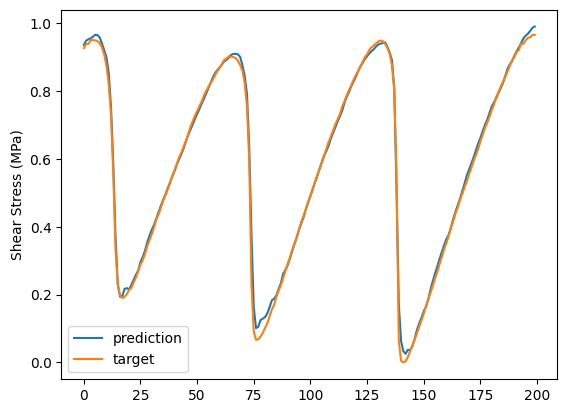

In [84]:
plt.plot(predicted[:200], label="prediction")
plt.plot(y_test[:200], label="target")
plt.ylabel('Shear Stress (MPa)')
plt.legend()
plt.show()

# part3 - large dataset

In [30]:
columns_name_p4581 = ['RecNum', 'LP_disp', 'Shr_stress', 'nor_disp', 'Nor_stress', 'Time', 'mu', 'layer_thick', 'Samp_Freq']
columns_name_p4679 = ['RecNum', 'LP_Disp', 'Shr_stress', 'nor_disp', 'Nor_stress', 'Time', 'mu', 'layer_thick', 'ec_disp']
columns_name_p5198 = ['RecNum', 'LP_Disp', 'Shr_stress', 'nor_disp', 'Nor_stress', 'Time', 'Sync', 'OnBoard', 'SlipVel', 'layer_thick', 'mu', 'ShearStrain']

In [32]:
with open(path+'p4581_data.txt', 'r') as f:
  data_p4581 = pandas.read_csv(f, sep="\s+", skiprows=5, names=columns_name_p4581)
data_p4679 = pandas.read_csv(path+"p4679.txt", skiprows=2, names=columns_name_p4679)
data_p5198 = pandas.read_csv(path+"p5198_data.txt", skiprows=2, names=columns_name_p5198)

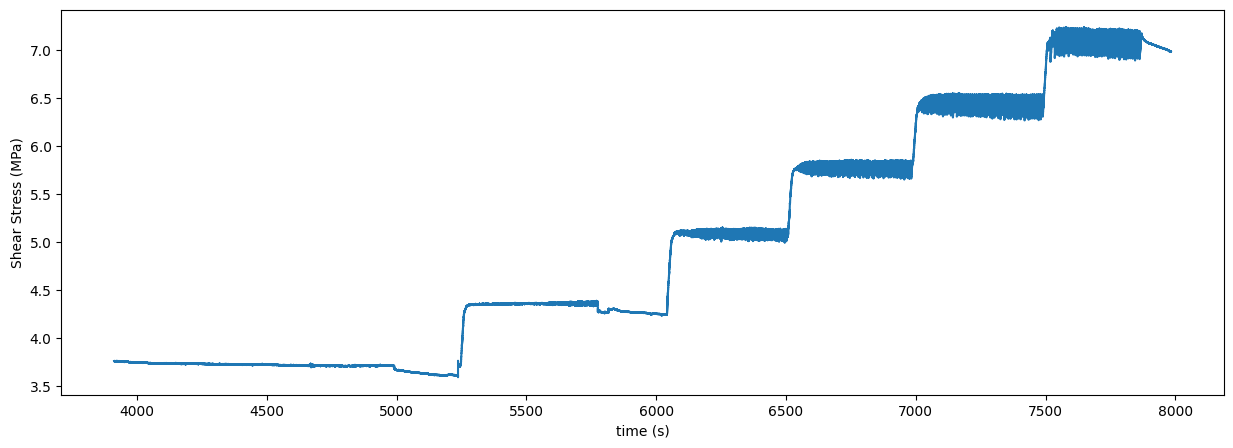

In [41]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(data_p5198["Time"][1000000:], data_p5198["Shr_stress"][1000000:])
ax.set_xlabel('time (s)')
ax.set_ylabel('Shear Stress (MPa)')
plt.show()

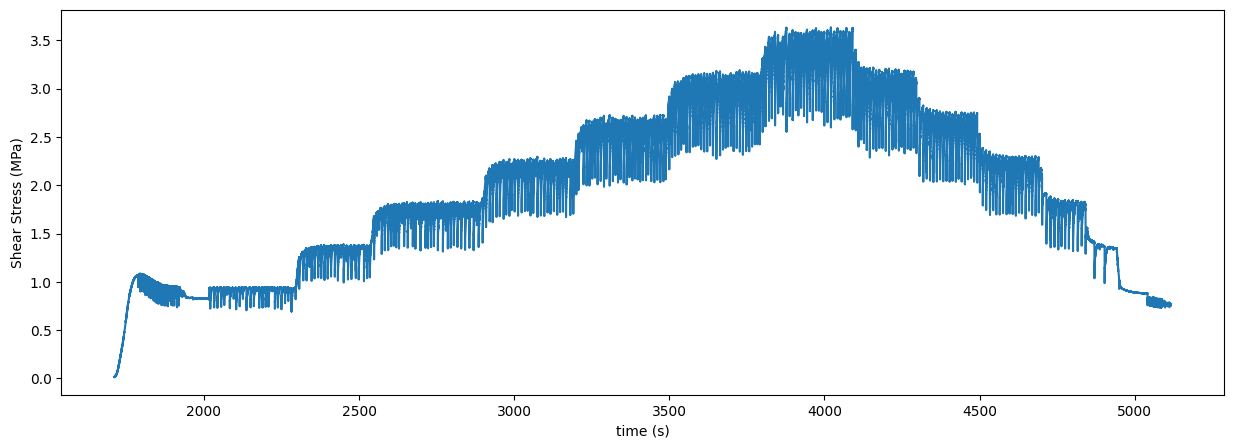

In [45]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(data_p4581["Time"][100000:], data_p4581["Shr_stress"][100000:])
ax.set_xlabel('time (s)')
ax.set_ylabel('Shear Stress (MPa)')
plt.show()

In [107]:
data_p4581_scale = data_p4581[1890000:2185000]
data_p4679_scale = data_p4679[2225000:2525000]
data_p5198_scale = data_p5198[4168000:4473000]

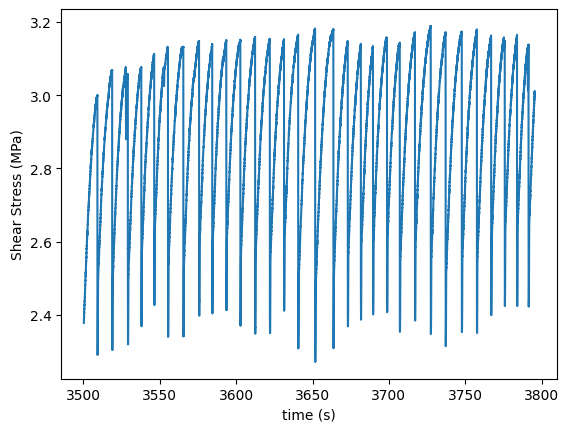

In [108]:
plt.plot(data_p4581_scale["Time"],data_p4581_scale["Shr_stress"])
plt.xlabel('time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.show()

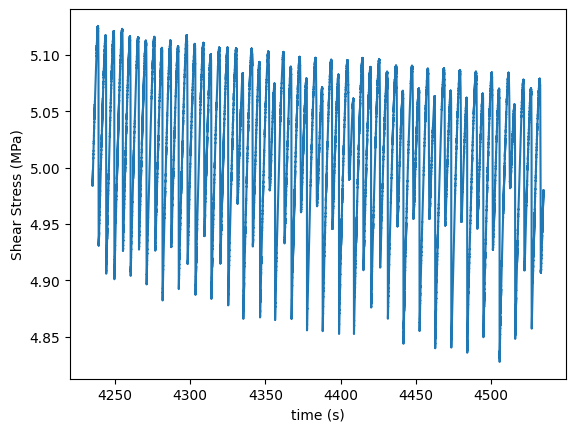

In [ ]:
plt.plot(data_p4679_scale["Time"],data_p4679_scale["Shr_stress"])
plt.xlabel('time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.show()

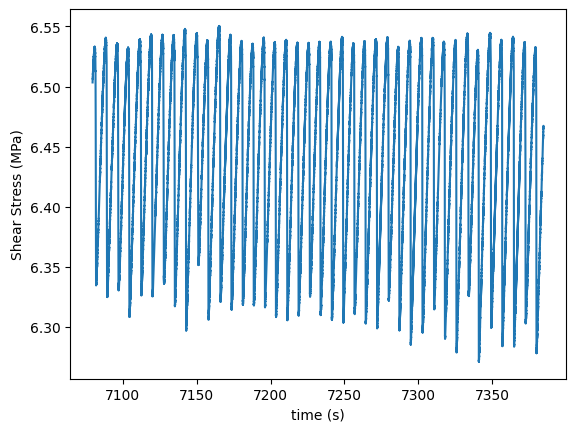

In [ ]:
plt.plot(data_p5198_scale["Time"],data_p5198_scale["Shr_stress"])
plt.xlabel('time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.show()

In [ ]:
# get possible interval
# end
prev = data_p5198.loc[4170000, "Shr_stress"]
for i in range(4170010, 4502000, 10):
  if prev < data_p5198.loc[i, "Shr_stress"]:
    print(i)
    break
  prev = data_p5198.loc[i, "Shr_stress"]
# start
prev = data_p5198.loc[4168000, "Shr_stress"]
for i in range(4168010, 4502000, 10):
  if prev > data_p5198.loc[i, "Shr_stress"]:
    print(i)
    break
  prev = data_p5198.loc[i, "Shr_stress"]

4170360
4168060


In [109]:
data_p4581.loc[2185000, "Time"]

3795.39

In [110]:
# get ShearStress, TTsF, TTeF by time
def calculate_TTsF_TTeF(df_shear_stress, df_time):
  starting = []
  ending = []
  temp_prev = None
  is_increasing = False
  shr_stress = []
  TTsF = []
  TTeF = []
  for (index, row) in df_time.iterrows():
    # filtered_rows = df_shear_stress[df_shear_stress["Time"] == round(row['time'], 3)]
    # index_value = filtered_rows.index[0]
    filtered_rows = df_shear_stress[df_shear_stress["Time"] == round(row['time'], 2)]
    index = int(row['time'] * 1000) % 10
    index_value = filtered_rows.index[index]
    shr_stress.append(filtered_rows.loc[index_value, "Shr_stress"])
    if temp_prev is not None and is_increasing and temp_prev > shr_stress[-1]:
      is_increasing = False
      starting.append(round(row['time'], 3))
    if temp_prev is not None and (not is_increasing) and temp_prev < shr_stress[-1]:
      is_increasing = True
      ending.append(round(row['time'], 3))
    temp_prev = shr_stress[-1]
  # one more TTsF and TTeF
  more_s = False
  more_e = False
  while not more_s or not more_e:
    index_value += 10
    if is_increasing and temp_prev > df_shear_stress.loc[index_value, "Shr_stress"]:
      is_increasing = False
      more_s = True
      starting.append(df_shear_stress.loc[index_value, "Time"])
    if not is_increasing and temp_prev < df_shear_stress.loc[index_value, "Shr_stress"]:
      is_increasing = True
      more_e = True
      ending.append(df_shear_stress.loc[index_value, "Time"])

  ttsf_count = 0
  ttef_count = 0
  for (index, row) in df_time.iterrows():
    TTsF.append(starting[ttsf_count] - round(row['time'], 3))
    TTeF.append(ending[ttef_count] - round(row['time'], 3))
    if TTsF[-1] == 0.0:
      ttsf_count += 1
    if TTeF[-1] == 0.0:
      ttef_count += 1
  df_time["Shr_stress"] = shr_stress
  df_time["TTsF"] = TTsF
  df_time["TTeF"] = TTeF

In [112]:
# p5198
# df_time_p5198 = pandas.read_csv(path+"variance_p5198.csv")
df_time_p4581 = pandas.read_csv(path+"variance_p4581_new.csv")
calculate_TTsF_TTeF(data_p4581, df_time_p4581)

In [113]:
df_time_p4581

,time,var1,var2,skew1,skew2,kurt1,kurt2,entropy1,entropy2,entropy change1,entropy change2,Shr_stress,TTsF,TTeF
0,3499.890433,135028.090500,209088.72070,0.125993,0.589043,1416.390688,1013.239861,-947.655297,-834.647559,947.655297,834.647559,2.16691,8.901,0.100
1,3499.990436,134632.177800,206676.28780,0.126016,0.609063,1424.714990,1034.930751,-975.607760,-926.583012,975.607760,926.583012,2.17429,8.801,0.000
2,3500.090440,134335.423800,206339.24560,0.126980,0.611196,1430.963012,1038.289085,-1005.718508,-962.453607,1005.718508,962.453607,2.22198,8.701,8.801
3,3500.190443,134168.022400,205468.69060,0.126841,0.615248,1434.532802,1047.072176,-1035.615097,-1043.028852,1035.615097,1043.028852,2.33025,8.601,8.701
4,3500.290400,1537.885200,2428.05480,0.069573,0.194447,108.132220,132.915110,-9496.228800,-6689.324500,9496.228800,6689.324500,2.36468,8.501,8.601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2945,3794.393410,930.690434,1730.68347,-0.024408,-0.618589,232.650102,1691.761570,-11954.388100,-7511.482170,11954.388100,7511.482170,2.92337,6.467,8.577
2946,3794.493400,899.389679,1786.93914,-0.192279,-0.383091,219.581073,1612.026940,-12467.204600,-7207.848860,12467.204600,7207.848860,2.92903,6.367,8.477
2947,3794.593400,1022.155110,1858.83297,-0.087542,-0.346312,286.635108,1494.901340,-10757.230700,-7072.484400,10757.230700,7072.484400,2.93957,6.267,8.377
2948,3794.693400,905.482613,1833.43085,0.119869,-0.357950,248.315315,1535.804520,-12325.885200,-7086.628130,12325.885200,7086.628130,2.94912,6.167,8.277


In [114]:
# df_time_p5198.to_csv('old_data_p5198.csv', index=False)
df_time_p4581.to_csv('new_data_p4581.csv', index=False)

In [72]:
train_df_5198 = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "var2", "kurt1", "kurt2", "Shr_stress"]]
val_test_df_5198 = pandas.read_csv(path+"new_data_p5198.csv")[["var1", "var2", "kurt1", "kurt2", "Shr_stress"]]

In [53]:
train_df_5198 = pandas.read_csv(path+"old_data_p5198.csv")[["var1", "kurt1", "entropy1", "entropy change1", "TTsF"]]
val_test_df_5198 = pandas.read_csv(path+"new_data_p5198.csv")[["var1", "kurt1", "entropy1", "entropy change1", "TTsF"]]

In [67]:
train_df_4581 = pandas.read_csv(path+"new_data_p4581.csv")[["var2", "entropy change2", "Shr_stress"]]
val_test_df_4581 = pandas.read_csv(path+"old_data_p4581.csv")[["var2", "entropy change2", "Shr_stress"]]

In [61]:
train_df_4581 = pandas.read_csv(path+"new_data_p4581.csv")[["var2", "entropy change2", "TTsF"]]
val_test_df_4581 = pandas.read_csv(path+"old_data_p4581.csv")[["var2", "entropy change2", "TTsF"]]

In [32]:
def train_split_func(dataset_train, steps):
  training_set = dataset_train.iloc[:, 0:dataset_train.shape[1]].values
  sc = MinMaxScaler()
  training_set_scaled = sc.fit_transform(training_set)
  print("training_set.shape: ",training_set.shape)
  X_train = []
  y_train = []
  for i in range(steps, training_set.shape[0]):
      X_train.append(training_set_scaled[i-steps:i, 0:training_set.shape[1]-1])
      y_train.append(training_set_scaled[i, training_set.shape[1]-1:])
  X_train, y_train = np.array(X_train), np.array(y_train)
  print("X_train.shape: ",X_train.shape)
  print("y_train.shape: ",y_train.shape)

  return X_train, y_train

In [73]:
# old step as training, new part as val and testing
X_train_new, y_train_new = train_split_func(train_df_5198, 70)
# X_train_new, y_train_new = train_split_func(df_p5198, 70)
X_val_new, y_val_new, X_test_new, y_test_new = train_test_split_func(val_test_df_5198, 0.5, 70)

training_set.shape:  (3100, 5)
X_train.shape:  (3030, 70, 4)
y_train.shape:  (3030, 1)
training_set.shape:  (1550, 5)
X_train.shape:  (1480, 70, 4)
y_train.shape:  (1480, 1)
X_test.shape:  (1480, 70, 4)
y_test.shape:  (1480, 1)


In [68]:
X_train_new, y_train_new = train_split_func(train_df_4581, 70)
X_val_new, y_val_new, X_test_new, y_test_new = train_test_split_func(val_test_df_4581, 0.5, 70)

training_set.shape:  (2950, 3)
X_train.shape:  (2880, 70, 2)
y_train.shape:  (2880, 1)
training_set.shape:  (1475, 3)
X_train.shape:  (1405, 70, 2)
y_train.shape:  (1405, 1)
X_test.shape:  (1405, 70, 2)
y_test.shape:  (1405, 1)


In [34]:
early_stopping = 40
max_epoch = 250

In [74]:
np.random.seed(1234)
rn.seed(1234)
tf.random.set_seed(1234)
if device == 'cuda':
  os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

class myCallback(tf.keras.callbacks.Callback):
  def __init__(self):
    super().__init__()
    self.testResults=[]
  def on_epoch_end(self, epoch, logs={}):
      restest=model.predict(X_test_new)
      testResults.append(mean_squared_error(y_test_new,restest))


testResults=[]
inp = Input(shape=(X_train_new.shape[1], X_train_new.shape[2]))
x = BatchNormalization()(inp)
x = LSTM(128,return_sequences=True)(x)
x = Convolution1D(128, (2),activation='relu', padding="same")(x)
x = Convolution1D(84, (2),activation='relu', padding="same")(x)
x = Convolution1D(64, (2),activation='relu', padding="same")(x)

x = Flatten()(x)

x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)


ttf = Dense(1, activation='relu',name='regressor')(x)

model = models.Model(inputs=inp, outputs=ttf)
model.get_weights()

# train
opt = optimizers.Nadam(learning_rate=0.008)

model.compile(optimizer = opt, loss = 'mean_squared_error')

checkpoint_filepath = 'model.hdf5'
cb_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss',mode='min', save_weights_only=True,save_best_only=True)
cb_Early_Stop = EarlyStopping(monitor='val_loss',patience=early_stopping,mode='min', verbose=1)
cb_Reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


callbacks = [cb_checkpoint,cb_Early_Stop,cb_Reduce_LR, myCallback()]

os.environ['PYTHONHASHSEED'] = '0'
session_conf = tf.compat.v1.ConfigProto(allow_soft_placement=True)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

K.set_session(sess)

history=model.fit(X_train_new, y_train_new, epochs=max_epoch,callbacks=callbacks, batch_size=256,verbose=1,validation_data=(X_val_new, y_val_new))

Epoch 1/250
12/12 [==============================] - 10s 470ms/step - loss: 2.3212 - val_loss: 0.0485 - lr: 0.0080
Epoch 2/250
12/12 [==============================] - 5s 393ms/step - loss: 0.0487 - val_loss: 0.1415 - lr: 0.0080
Epoch 3/250
12/12 [==============================] - 6s 490ms/step - loss: 0.0052 - val_loss: 0.1331 - lr: 0.0080
Epoch 4/250
12/12 [==============================] - 4s 373ms/step - loss: 0.0050 - val_loss: 0.1058 - lr: 0.0080
Epoch 5/250
12/12 [==============================] - 4s 386ms/step - loss: 0.0028 - val_loss: 0.0969 - lr: 0.0080
Epoch 6/250
12/12 [==============================] - 4s 361ms/step - loss: 0.0022 - val_loss: 0.0814 - lr: 0.0080
Epoch 7/250
12/12 [==============================] - 4s 369ms/step - loss: 0.0018 - val_loss: 0.0694 - lr: 0.0040
Epoch 8/250
12/12 [==============================] - 5s 446ms/step - loss: 0.0017 - val_loss: 0.0626 - lr: 0.0040
Epoch 9/250
12/12 [==============================] - 5s 410ms/step - loss: 0.0015 - val

In [64]:
# train loss
test_step(model, X_train_new, y_train_new, 70)

90/90 [==============================] - 2s 26ms/step
Test r2_score: 0.92999
Test RMSE: 0.06465
23/23 [==============================] - 1s 55ms/step - loss: 0.0042
test loss: 0.004234971012920141


(0.06465402764170135, 0.9299883483349337, 0.004234971012920141)

In [65]:
test_step(model, X_test_new, y_test_new, 70)

44/44 [==============================] - 1s 28ms/step
Test r2_score: 0.44664
Test RMSE: 0.19564
11/11 [==============================] - 1s 58ms/step - loss: 0.0366
test loss: 0.036559928208589554


(0.19564372601592558, 0.4466373583223242, 0.036559928208589554)

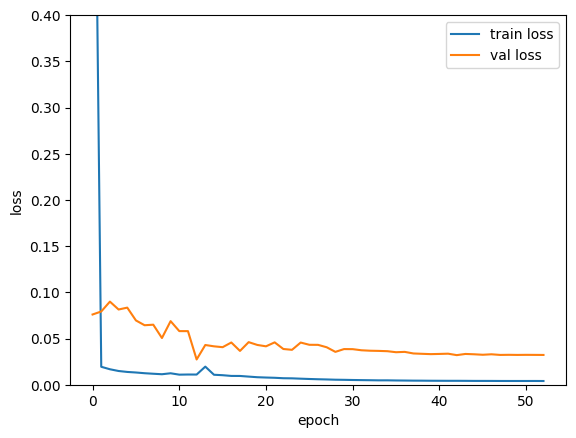

In [66]:
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 0.4])
plt.legend()
plt.show()

In [75]:
predicted = model.predict(X_test_new,verbose=1 )

47/47 [==============================] - 1s 26ms/step


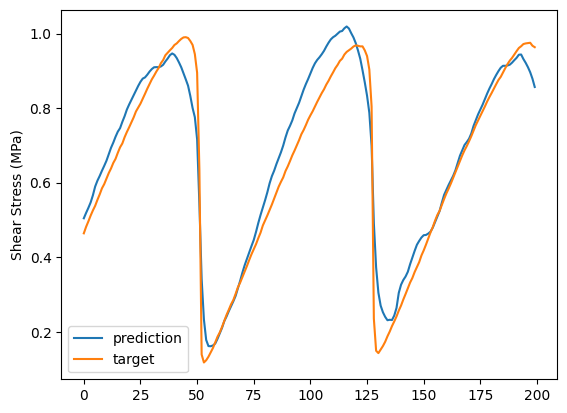

In [78]:
plt.plot(predicted[0:200], label="prediction")
plt.plot(y_test_new[0:200], label="target")
plt.ylabel('Shear Stress (MPa)')
plt.legend()
plt.show()